<a href="https://colab.research.google.com/github/Patatone/Analysis-of-the-COVID-19-impact-on-LTE-Networks/blob/main/Analysis_of_the_COVID_19_impact_on_LTE_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
%pip install geopandas
%pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
import numpy as np
import pandas as pd
import geopandas
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from google.colab import files
from google.colab import data_table

# Enable "data_table" visualization
data_table.enable_dataframe_formatter()

# Import Data


In [96]:
from google.colab import drive
import glob
import os

# Use this Section to import the data files provided in the project folder.

# NETWORK KPI
# Location: Milan ; Reference month: either January, February or March 2020:

## Google drive required lines
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/MRN_data/'

## Local path required lines
# file_path = ''

# KPIs
# We select January, February and March
all_files = glob.glob(os.path.join(file_path , "Milano_800*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Cells Location:
locations = pd.read_csv(file_path+'Coordinates_MILANO.csv')

# Drop all possible duplicate rows and drop all possible rows with any NaN and NaT values
locations = locations.drop_duplicates().dropna()

# https://pandas.pydata.org

# This section shows some information regarding the dataset
print(20*'*')
print('Data types:\n')
print(data.dtypes)
print(20*'*')  
print('Number of data points: ', len(data))
print('Number of columns in the dataset: ', len(data.columns))
print(20*'*')
print(data.isnull().sum(axis=0)) # this command show the number of NON valid data points for each column of the dataset:
                                 # a KPI measure for some timestamp can get lost during the storing procedure
print(20*'*')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
********************
Data types:

REGIONE                    object
COMUNE                     object
Date               datetime64[ns]
ECELL_ID                   object
DL_BW                     float64
RRC_S_SR                  float64
RRC_RE_SR                 float64
ERAB_S_SR                 float64
CS_SR                     float64
IntraF_Hout_SR            float64
InterF_Hout_SR            float64
Hin_SR                    float64
DL_VOL                    float64
UL_VOL                    float64
DL_THR_AVG                float64
UL_THR_AVG                float64
DL_THR_MAX                float64
UL_THR_MAX                float64
USERNUM_MAX               float64
PRB_DL_Used_Avg           float64
PRB_UL_Used_Avg           float64
dtype: object
********************
Number of data points:  841085
Number of columns in the dataset:  21
*******************

In [97]:
# Here you can understand the size of the scenario, 
# i.e., how many cells you are considering.
print('Number of (distinct) cells: ', len(locations.drop_duplicates(subset='ECELL_ID')))
print('Number of (distinct) used cells: ', len(data.drop_duplicates(subset='ECELL_ID')))
print('Number of (distinct) eNodeB: ', len(locations.drop_duplicates(subset='ENODEB_ID')))
join_data = data.join(locations.set_index('ECELL_ID'), on='ECELL_ID')

N_NODEB =len(join_data.drop_duplicates(subset='ENODEB_ID'))
print('Number of (distinct) used eNodeB: ', N_NODEB)

Number of (distinct) cells:  962
Number of (distinct) used cells:  398
Number of (distinct) eNodeB:  181
Number of (distinct) used eNodeB:  139


# Data Pre-Processing

In [98]:
# We can split the dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown_end_date = pd.Timestamp(year=2020, month=4, day=1, hour = 0, minute =1)
full_lockdown_start_date = pd.Timestamp(year=2020, month=3, day=8, hour = 23, minute =59)

restrictions_end_date = pd.Timestamp(year=2020, month=3, day=10, hour = 0, minute =1)
restrictions_start_date = pd.Timestamp(year=2020, month=2, day=15, hour = 23, minute =59)

covid_free_end_date = pd.Timestamp(year=2020, month=2, day=17, hour = 0, minute =1)
covid_free_start_date = pd.Timestamp(year=2019, month=12, day=12, hour = 23, minute =59)


full_lockdown = data[data['Date'] < full_lockdown_end_date]
full_lockdown = full_lockdown[full_lockdown['Date'] > full_lockdown_start_date]

restrictions = data[data['Date'] < restrictions_end_date]
restrictions = restrictions[restrictions['Date'] > restrictions_start_date]

covid_free = data[data['Date'] < covid_free_end_date]
covid_free = covid_free[covid_free['Date'] > covid_free_start_date]


In [99]:
# PRE-PROCESSING DATA FOR CLUSTERING 

# Hours filtering
x = covid_free[covid_free['Date'].dt.hour.between(6, 24)]

x['Hour'] = pd.to_datetime(x['Date']).dt.hour
x['Weekday'] = x['Date'].dt.weekday

x = x.join(locations.set_index('ECELL_ID'), on='ECELL_ID')

# Creating dataset with relevant data from previous DataFrame
x = x[['ENODEB_ID', 'DL_VOL', 'Hour', 'Weekday']]
display(x)

# Splitting between week and weekend days
x['Weekday'] = x['Weekday'].apply(lambda x : 0 if x < 5 else (1 if x == 5 else 2))

# Perform the median on the DL_VOL
x = x.groupby(['ENODEB_ID', 'Hour', 'Weekday'], as_index=False).agg({'ENODEB_ID': 'first', 'DL_VOL': 'median', 'Hour': 'first', 'Weekday': 'first'})
x = x.reset_index(drop=True)

display(x)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


ENODEB_ID      DL_VOL  Hour  Weekday
283378  930b285c764e554f338f671864b30d3941935b00  31770560.0    12        5
283379  930b285c764e554f338f671864b30d3941935b00  29351280.0    17        5
283380  930b285c764e554f338f671864b30d3941935b00  21261520.0    16        5
283381  930b285c764e554f338f671864b30d3941935b00  28403648.0    15        5
283382  930b285c764e554f338f671864b30d3941935b00  32426144.0    14        5
...                                          ...         ...   ...      ...
841080  3fdbc872d547a3c5b6404cb90960ed717085fa0b  14161896.0    15        3
841081  3fdbc872d547a3c5b6404cb90960ed717085fa0b  12487416.0    13        3
841082  3fdbc872d547a3c5b6404cb90960ed717085fa0b  15583752.0    12        3
841083  3fdbc872d547a3c5b6404cb90960ed717085fa0b  15207120.0    20        3
841084  3fdbc872d547a3c5b6404cb90960ed717085fa0b  15373656.0    14        3

[325644 rows x 4 columns]

ENODEB_ID      DL_VOL  Hour  Weekday
0     0215f23cbc0c6fed80ce30cb131bc9ed2a745328   3694572.0     6        0
1     0215f23cbc0c6fed80ce30cb131bc9ed2a745328   2695936.0     6        1
2     0215f23cbc0c6fed80ce30cb131bc9ed2a745328   2866480.0     6        2
3     0215f23cbc0c6fed80ce30cb131bc9ed2a745328   1661272.0     7        0
4     0215f23cbc0c6fed80ce30cb131bc9ed2a745328    775160.0     7        1
...                                        ...         ...   ...      ...
7501  fedae7d9d5021026b90211ad6e640aba57634d8e   8411016.0    22        1
7502  fedae7d9d5021026b90211ad6e640aba57634d8e  12332144.0    22        2
7503  fedae7d9d5021026b90211ad6e640aba57634d8e   8439460.0    23        0
7504  fedae7d9d5021026b90211ad6e640aba57634d8e   8705952.0    23        1
7505  fedae7d9d5021026b90211ad6e640aba57634d8e  10940464.0    23        2

[7506 rows x 4 columns]

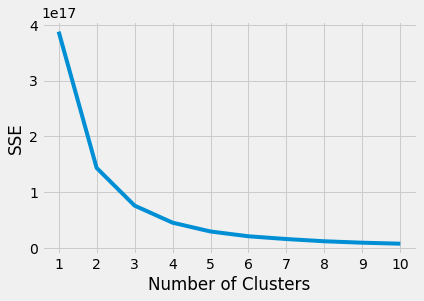


Perfect "k" value for the KMeans algorithm: 3



In [100]:
# Determining "k" for K-Means Clustering

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
    }

# Selecting the columns for the k-means clustering algorithm
dl_array = x[['DL_VOL', 'Hour', 'Weekday']]
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  identified_clusters = kmeans.fit(dl_array)
  sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
print()

# Determining the elbow point in the SSE curve
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
k = kl.elbow
print('Perfect "k" value for the KMeans algorithm:', k)
print()

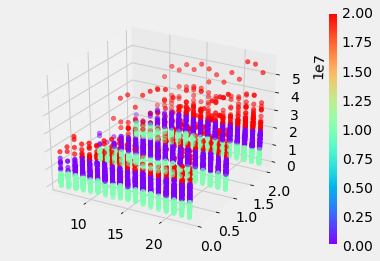

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ENODEB_ID  Clusters
0    0215f23cbc0c6fed80ce30cb131bc9ed2a745328         1
1    06aae15c9629c9678edd56657192be30db5934d4         1
2    097e1d4a277e6d01e669ce5cc4451385373f765c         0
3    0b3ac99f984ed5eebd90e63eb0cd243e80fe0122         0
4    0c37e6369bb6f6804dd9a9520f9f09e09e659dac         0
..                                        ...       ...
134  f3d8f663b55d0e09e776e3144bf1ccdb6fad4048         0
135  f9ea6c0f0f54b40ac1d2a71da53b398109f7b379         1
136  fad7e3b8304ec998840271a7a79029a250592fe3         1
137  fb1af0ff1366d50bd7545ce7f6bb487a005153e9         1
138  fedae7d9d5021026b90211ad6e640aba57634d8e         0

[139 rows x 2 columns]

The number of clustered eNodeB matches with the total: 139


In [101]:
# CLUSTERING

# creating a "k" clusters k-means value clustering class and fitting the DataFrame accordingly
kmeans = KMeans(n_clusters=k).fit(dl_array)
identified_clusters = kmeans.fit_predict(dl_array)
data_with_clusters = x.copy()
data_with_clusters['Clusters'] = identified_clusters

# Scattering the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(data_with_clusters['Hour'], data_with_clusters['Weekday'], data_with_clusters['DL_VOL'], c = data_with_clusters['Clusters'],
            cmap='rainbow')
fig.colorbar(img)
plt.show()
print()

# Download csv
data_with_clusters.to_csv('df.csv')
files.download('df.csv')

# Set the final Clusters based on the number of Clusters values
data_with_clusters = data_with_clusters.groupby('ENODEB_ID')['Clusters'].apply(lambda x: x.value_counts().index[0]).reset_index()
display(data_with_clusters)

# Number of eNodeB check
CLUSTERED_N_NODEB = len(data_with_clusters.drop_duplicates(subset='ENODEB_ID'))
if (len(data_with_clusters.drop_duplicates(subset='ENODEB_ID')) == N_NODEB ):
  print("The number of clustered eNodeB matches with the total:", N_NODEB)
else:
  print("PROBLEM: The number of clustered eNodeB DOESN'T match with the total {} and {}".format(CLUSTERED_N_NODEB, N_NODEB))

In [102]:
# SPLITTING DATA PHASE

# Splitting cells
support_cl1 = data_with_clusters[data_with_clusters['Clusters'] == 0]
support_cl3 = data_with_clusters[data_with_clusters['Clusters'] == 1]
support_cl2 = data_with_clusters[data_with_clusters['Clusters'] == 2]

support_cl1 = support_cl1.reset_index()
support_cl2 = support_cl2.reset_index()
support_cl3 = support_cl3.reset_index()

C1_ENODEB_LEN =  len(support_cl1.drop_duplicates(subset='ENODEB_ID'))
print('Number of (distinct) eNodeBs Cluster 1: ', C1_ENODEB_LEN)
C2_ENODEB_LEN = len(support_cl2.drop_duplicates(subset='ENODEB_ID'))
print('Number of (distinct) eNodeBs Cluster 2: ', C2_ENODEB_LEN)
C3_ENODEB_LEN = len(support_cl3.drop_duplicates(subset='ENODEB_ID'))
print('Number of (distinct) eNodeBs Cluster : ', C3_ENODEB_LEN)
print('Total (distinct) splitted eNodeBs : ', C1_ENODEB_LEN + C2_ENODEB_LEN + C3_ENODEB_LEN)
print('Number of (distinct) used eNodeB: ', N_NODEB)


data_enodebs = data.join(locations.set_index('ECELL_ID'), on='ECELL_ID')

# Splitting all the data according to the clusters
cl1_data = data.loc[data_enodebs['ENODEB_ID'].isin(support_cl1['ENODEB_ID'])].reset_index(drop=True)
cl2_data = data.loc[data_enodebs['ENODEB_ID'].isin(support_cl2['ENODEB_ID'])].reset_index(drop=True)
cl3_data = data.loc[data_enodebs['ENODEB_ID'].isin(support_cl3['ENODEB_ID'])].reset_index(drop=True)

# Splitting all the locations according to the clusters
cl1_locations = locations.loc[locations['ENODEB_ID'].isin(support_cl1['ENODEB_ID'])].reset_index(drop=True)
cl2_locations = locations.loc[locations['ENODEB_ID'].isin(support_cl2['ENODEB_ID'])].reset_index(drop=True)
cl3_locations = locations.loc[locations['ENODEB_ID'].isin(support_cl3['ENODEB_ID'])].reset_index(drop=True)

display(cl1_locations)
display(cl2_locations)
display(cl3_locations)

print('Number of (distinct) used cells0: ', len(data_enodebs.drop_duplicates(subset='ECELL_ID')))
print('Number of (distinct) used cells1: ', len(data.drop_duplicates(subset='ECELL_ID')))
print('Number of (distinct) total cells: ', len(locations.drop_duplicates(subset='ECELL_ID')))

C1_CELL_LEN = len(cl1_locations.drop_duplicates(subset='ECELL_ID'))
print('Number of (distinct) CELLs Cluster 1: ', C1_CELL_LEN)
C2_CELL_LEN = len(cl2_locations.drop_duplicates(subset='ECELL_ID'))
print('Number of (distinct) CELLs Cluster 2: ', C2_CELL_LEN)
C3_CELL_LEN = len(cl3_locations.drop_duplicates(subset='ECELL_ID'))
print('Number of (distinct) CELLs Cluster 3: ', C3_CELL_LEN)
print('Total (distinct) splitted CELLs : ', C1_CELL_LEN + C2_CELL_LEN + C3_CELL_LEN)


print(set.intersection(set(cl1_locations.ECELL_ID), set(cl2_locations.ECELL_ID)))
print(set.intersection(set(cl2_locations.ECELL_ID), set(cl3_locations.ECELL_ID)))
print(set.intersection(set(cl3_locations.ECELL_ID), set(cl1_locations.ECELL_ID)))

print(set.intersection(set(cl1_locations.ENODEB_ID), set(cl2_locations.ENODEB_ID)))
print(set.intersection(set(cl2_locations.ENODEB_ID), set(cl3_locations.ENODEB_ID)))
print(set.intersection(set(cl3_locations.ENODEB_ID), set(cl1_locations.ENODEB_ID)))

Number of (distinct) eNodeBs Cluster 1:  60
Number of (distinct) eNodeBs Cluster 2:  13
Number of (distinct) eNodeBs Cluster :  66
Total (distinct) splitted eNodeBs :  139
Number of (distinct) used eNodeB:  139


ENODEB_ID  \
0    6c6e77c44a598b0e34a0ff19832137cc24a31db7   
1    6c6e77c44a598b0e34a0ff19832137cc24a31db7   
2    6c6e77c44a598b0e34a0ff19832137cc24a31db7   
3    6c6e77c44a598b0e34a0ff19832137cc24a31db7   
4    6c6e77c44a598b0e34a0ff19832137cc24a31db7   
..                                        ...   
337  f161d41795890db558d3e34b6ddd61bda77e8764   
338  f161d41795890db558d3e34b6ddd61bda77e8764   
339  f161d41795890db558d3e34b6ddd61bda77e8764   
340  f161d41795890db558d3e34b6ddd61bda77e8764   
341  f161d41795890db558d3e34b6ddd61bda77e8764   

                                     ECELL_ID    LONG_X      LAT_Y  
0    6807ba8768ea1c61b922795a02dd6e8c1f5823e1  9.214511  45.469421  
1    8d22026fa4296af87b0cc18fe624dab8b4380f5f  9.214511  45.469421  
2    ec23991911b3cfb4ea95872ff7c33f3b94a4ed8c  9.214511  45.469421  
3    19f1db7780506e3ca6e4510fe9eacea8780b8a57  9.214511  45.469421  
4    118b2380aa908cf5dbb4dd9a2a7c7a8c01cf3df5  9.214511  45.469421  
..                                        ...       ...        ...  
337  dfee8b67dd0f806325484e2fd32e1bdcb93bd491  9.175056  45.460056  
338  963d7b7a00e2b9c7d20fe313dced0388be5b4dac  9.175056  45.460056  
339  6e400cb348d501fe7cc36f7dffe9f61ea2f0fda4  9.175056  45.460056  
340  7e071b24a187a5f5a51788325ba163393c2e747f  9.175056  45.460056  
341  eaeb76ef9572473210d34e31d7f172ad8f1745e8  9.175056  45.460056  

[342 rows x 4 columns]

ENODEB_ID  \
0   20dc89dfa2970fba49975c8021d729dbb93d9c86   
1   20dc89dfa2970fba49975c8021d729dbb93d9c86   
2   20dc89dfa2970fba49975c8021d729dbb93d9c86   
3   20dc89dfa2970fba49975c8021d729dbb93d9c86   
4   20dc89dfa2970fba49975c8021d729dbb93d9c86   
..                                       ...   
71  4098516471522b42b596da741a12b408af23877a   
72  4098516471522b42b596da741a12b408af23877a   
73  4098516471522b42b596da741a12b408af23877a   
74  4098516471522b42b596da741a12b408af23877a   
75  4098516471522b42b596da741a12b408af23877a   

                                    ECELL_ID    LONG_X      LAT_Y  
0   5a6ea208eb7b2dcbf59dc457706b8b04a5a8e1b2  9.193417  45.444824  
1   b713a4f2dc59f35a0dfa1e598cf4cf01659bd2e8  9.193417  45.444824  
2   b7eed02edd74696bf65d055085787772478961de  9.193417  45.444824  
3   54ebd03cfb35c525f14319bf13ec472fd48ff82d  9.193417  45.444824  
4   92a9a40e50f92b2225a357de69a69b986bd5b382  9.193417  45.444824  
..                                       ...       ...        ...  
71  6805bcdd345fe8aceaf193d5cd0efec689627cfd  9.196639  45.471111  
72  127cd95aaab8bc59186b5db827b82b2ffa4fc635  9.196639  45.471111  
73  0527e8c4cf3eb08af45d118c6783eed34f28bd50  9.196639  45.471111  
74  a03f758431bdd90bf1b2beef5f7f86df187bfeb8  9.196639  45.471111  
75  5a4c5dd189bc4570ffea2f0975f87f62861072da  9.196639  45.471111  

[76 rows x 4 columns]

ENODEB_ID  \
0    930b285c764e554f338f671864b30d3941935b00   
1    930b285c764e554f338f671864b30d3941935b00   
2    930b285c764e554f338f671864b30d3941935b00   
3    930b285c764e554f338f671864b30d3941935b00   
4    930b285c764e554f338f671864b30d3941935b00   
..                                        ...   
375  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
376  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
377  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
378  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
379  3fdbc872d547a3c5b6404cb90960ed717085fa0b   

                                     ECELL_ID    LONG_X      LAT_Y  
0    b7de6cd46e855aaec8e28b26d1767e7a738819db  9.208433  45.445358  
1    3821116bcdc789c9d54369ddd58b8e75fafdcb59  9.208433  45.445358  
2    9ed9d0f30e21c0218c987496c433e11dd611c9d2  9.208433  45.445358  
3    9ba7c2a7f2ae3a32003cd92d0ce82fdd734f1d7f  9.208433  45.445358  
4    ce8ca39728288e4065ec86b14e902807327427ff  9.208433  45.445358  
..                                        ...       ...        ...  
375  82a9f5269531147ac5ce15ff92fd8172d1ff0bcf  9.158972  45.505527  
376  3b99faafa552a3deb33f45826e79bec090cc4084  9.158972  45.505527  
377  2be222cdb25c37650735f9a18e575cdaec91e995  9.158972  45.505527  
378  5d0ba788e727644a8aeecdc64f230a63b1465c66  9.158972  45.505527  
379  f16a9dacc5b0409172f4c710cbffff5dc4d89210  9.158972  45.505527  

[380 rows x 4 columns]

Number of (distinct) used cells0:  398
Number of (distinct) used cells1:  398
Number of (distinct) total cells:  962
Number of (distinct) CELLs Cluster 1:  342
Number of (distinct) CELLs Cluster 2:  76
Number of (distinct) CELLs Cluster 3:  380
Total (distinct) splitted CELLs :  798
set()
set()
set()
set()
set()
set()


In [120]:
# We can split the CLUSTERED dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"


def split_dataset(dataset, start_date, end_date):
  ris = dataset[dataset['Date'] < end_date]
  return ris[ris['Date'] > start_date]


# List of data corresponding to each cluster  
cl_dataframes = [cl1_data, cl2_data, cl3_data]

# List of Full lockdown, Restrictions and Covid free dataset portion for each cluster
cl_periods_dataframes_list = [[], [], []]

for i in range(3):
  cl_periods_dataframes_list[i] = [split_dataset(cl_dataframes[i], covid_free_start_date, covid_free_end_date), 
                                   split_dataset(cl_dataframes[i], restrictions_start_date, restrictions_end_date), 
                                   split_dataset(cl_dataframes[i], full_lockdown_start_date, full_lockdown_end_date)]

periods_lables = ['Covid Free','Restrictions','Full Lockdown']
periods_data = [covid_free, restrictions, full_lockdown]
for i in range(0, 3):
  print('Number of', periods_lables[i], 'data points:', len(periods_data[i]))


Number of Covid Free data points: 434975
Number of Restrictions data points: 217267
Number of Full Lockdown data points: 208081


# Data Visualization

Original dataset size: 840295
Cleaned dataset size: 840295


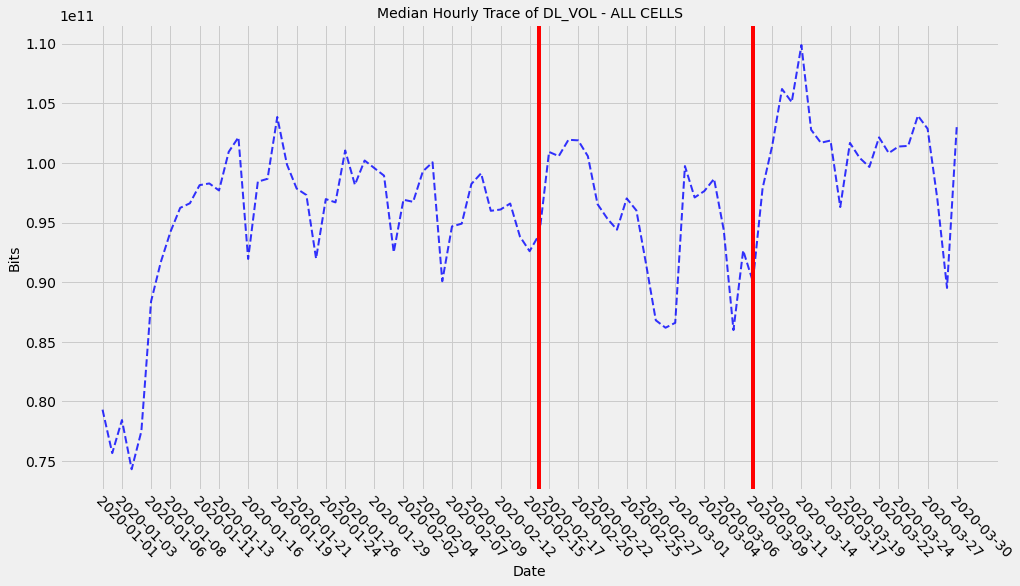


Original dataset size: 840295
Cleaned dataset size: 840295


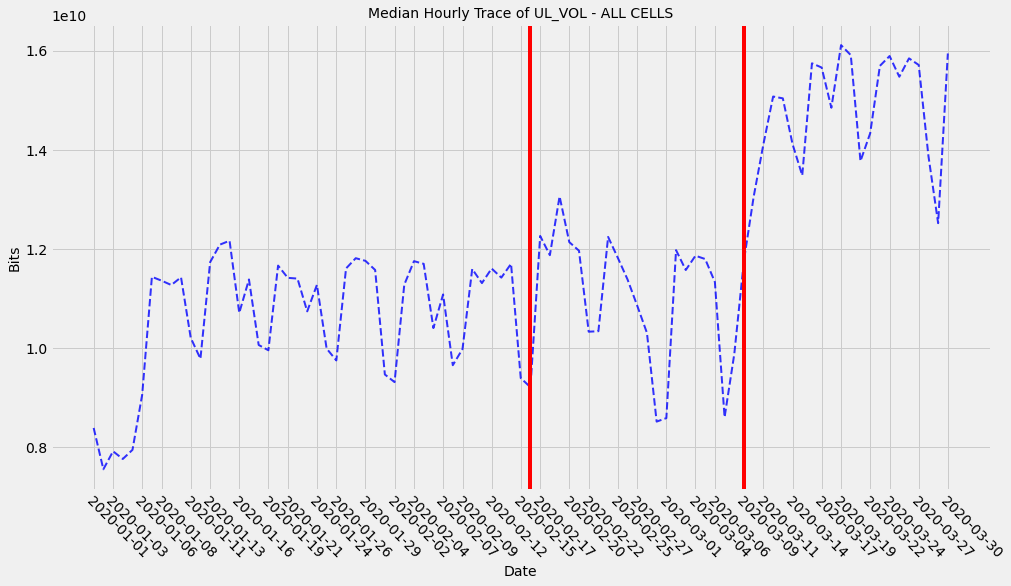

In [104]:
# This section plots the Traffic Downloaded from the ALL cells in a month

def periods_trace_plot_daily(ref_KPI, operation, ylabel):
  # Create a copy of the original dataset
  data_temp = data.copy()

  # Set Daily granularity instead of Hourly granularity
  data_temp['Date'] = pd.to_datetime(data_temp['Date']).dt.date

  # Used to identify days with less measurments
  # pd.set_option('display.max_rows', None)
  # display(data_temp['Date'].value_counts())

  # We drop the data about 31-03-2020 because we are computing daily stats and in this date we have only one measurment for the whole day
  ref = data_temp.set_index('Date').sort_values('Date').drop(datetime.date(year=2020,month=3,day=31)).loc[:, [ref_KPI]]

  print('Original dataset size:', len(ref))
  print('Cleaned dataset size:', len(ref.dropna()))

  # Sum all the "ref_KPI" values with same "Date"
  ref = ref.groupby(level=0).sum()

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  # plot data
  ax.plot(list(range(0,len(ref))), ref[ref_KPI], linestyle='--', lw=2, color='b', alpha=.8) 

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  ticks_label = ref.index
  ticks = np.linspace(0, len(ref)-1, 35, dtype=int)
  plt.xticks(ticks = ticks, labels = ticks_label[ticks], fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
  plt.xlabel('Date', color='black', fontsize=14)
  plt.ylabel(ylabel, color='black', fontsize=14) # unit of measure depends on the considered KPI
  plt.title('Median Hourly Trace of '+ref_KPI+' - ALL CELLS', fontsize=14)

  # Draw a red line when there is a period change
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=2,day=16)) ,color = 'r',label = 'Restrictions')
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=3,day=9)) ,color = 'r',label = 'Full Lockdown')

  plt.show()

periods_trace_plot_daily('DL_VOL', 0, 'Bits')
print()
periods_trace_plot_daily('UL_VOL', 0, 'Bits')
print()

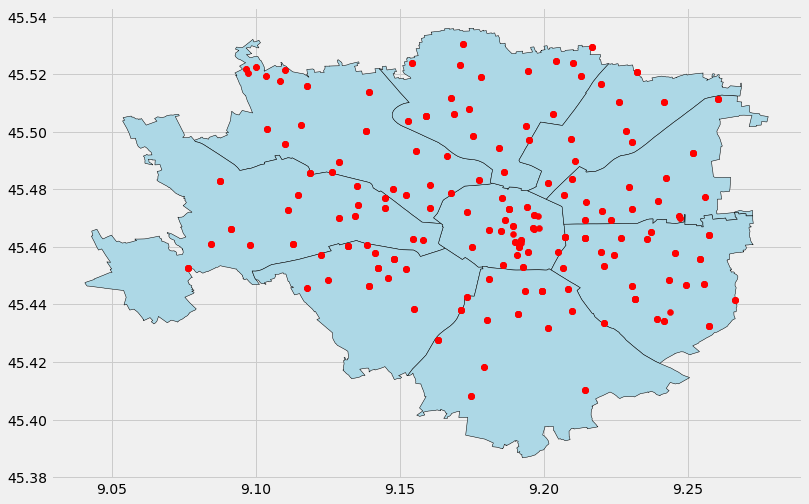

In [105]:
# Cell rappresentation with Geopandas
geo_data = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.LONG_X, locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data.plot(ax=ax, color='red')
plt.show()


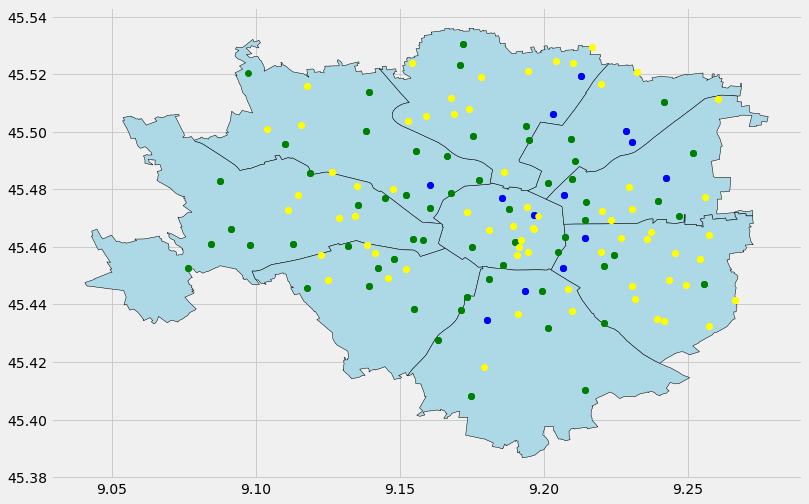

In [106]:
# Cell differentiation with Geopandas
geo_data_cl1 = geopandas.GeoDataFrame(cl1_locations, geometry=geopandas.points_from_xy(cl1_locations.LONG_X, cl1_locations.LAT_Y))
geo_data_cl2 = geopandas.GeoDataFrame(cl2_locations, geometry=geopandas.points_from_xy(cl2_locations.LONG_X, cl2_locations.LAT_Y))
geo_data_cl3  = geopandas.GeoDataFrame(cl3_locations, geometry=geopandas.points_from_xy(cl3_locations.LONG_X, cl3_locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data_cl1.plot(ax=ax, color='green')
geo_data_cl2.plot(ax=ax, color='blue')
geo_data_cl3.plot(ax=ax, color='yellow')
plt.show()

In [107]:
# This section makes a box plot of the daily statiscs regarding the number of connected 
# users to the cell taken as example. For each day, the following statistics are extracted from the considered
# KPI:
# - Median Value
# - 25th and 75th Quantiles
# - Max and Min values

# For reference about how to read a box plot go here: 
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51


def data_dataset_daily(dataset, ref_KPI):
  # Set Daily granularity instead of Hourly granularity
  dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
  # Set new dataset index to "Date" and keep only the "ref_KPI" column
  return dataset.set_index('Date').sort_values('Date').loc[:, [ref_KPI]]


# If operation == 0 do the sum of the ref_KPI of the day
# If operation == 1 do the average of the ref_KPI of the day
def dataset_operation(dataset, operation):
  if operation == 0:
    dataset = dataset.groupby(level=0).sum()
  else:
    dataset = dataset.groupby(level=0).mean()
  return dataset


def statistical_comparison(periods_lables, median_values, average_values, sd_values, id_1, id_2, ref_KPI):
  print('>>>------', periods_lables[id_1], ref_KPI, 'Variation ------<<<')
  print("Median: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((median_values[id_2] - median_values[id_1]) / abs(median_values[id_1])) * 100))
  print("Average: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((average_values[id_2] - average_values[id_1]) / abs(average_values[id_1])) * 100))
  print("Std. deviation: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((sd_values[id_2] - sd_values[id_1]) / abs(sd_values[id_1])) * 100))


def periods_box_plot_daily(periods, periods_lables, ref_KPI, operation, ylabel):

  periods_copy = []
  periods_data_list = []
  N_periods = len(periods)

  for i in range(N_periods):
    periods_copy.append(periods[i].copy())
    periods_copy[i] = data_dataset_daily(periods_copy[i], ref_KPI)
    periods_copy[i] = periods_copy[i].loc[:, [ref_KPI]].drop(datetime.date(year=2020,month=3,day=31), errors='ignore')
    # Remove null values
    periods_copy[i] = periods_copy[i].dropna()
    periods_copy[i] = dataset_operation(periods_copy[i], ref_KPI)
    # periods_copy have only one KPI but we need "[ref_KPI]" to use the "tolist()" function
    periods_data_list.append(periods_copy[i][ref_KPI].tolist())

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  bplots = []
  for i in range(N_periods):
    bplots.append(ax.boxplot(periods_data_list[i], positions = [i], patch_artist=True))

  for bplot in bplots:
    for patch in bplot['boxes']:
      patch.set_facecolor('lightblue')

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  plt.xticks(ticks = list(range(N_periods)), labels = periods_lables, fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), ha="center") 
  plt.ylabel(ylabel, color='black', fontsize=14)
  if N_periods > 3:
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 

  plt.title('Box Plot of Median '+ref_KPI+' - ALL CELLs', fontsize=14)
  plt.show()

  print()
  
  median_values = []
  average_values = []
  sd_values = []

  # Print statistical informations:
  for i in range(N_periods):
    print('---------', periods_lables[i], ref_KPI,'---------')
    median_values.append(np.median(periods_data_list[i]))
    print('Median value:', "{0:.2f}".format(median_values[i]))
    average_values.append(np.mean(periods_data_list[i]))
    print('Average value:', "{0:.2f}".format( average_values[i]))
    sd_values.append(np.std(periods_data_list[i]))
    print('Standard deviation:', "{0:.2f}".format(sd_values[i]))

  if N_periods > 3:
    # Statistical comparison between residential and business in the same period
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 4, 5, ref_KPI)

    # Statistical comparison between residential periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 4, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 4, ref_KPI)

    # Statistical comparison between business periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 5, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 3, 5, ref_KPI)
  else:
    # Statistical comparison between periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 2, ref_KPI)


In [108]:
def plot_stats(periods, periods_lables):
  periods_box_plot_daily(periods, periods_lables, 'DL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'ERAB_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'CS_SR', 1, 'Calls')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_RE_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'IntraF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'InterF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'Hin_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_DL_Used_Avg', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_UL_Used_Avg', 1, 'Bits')
  print()

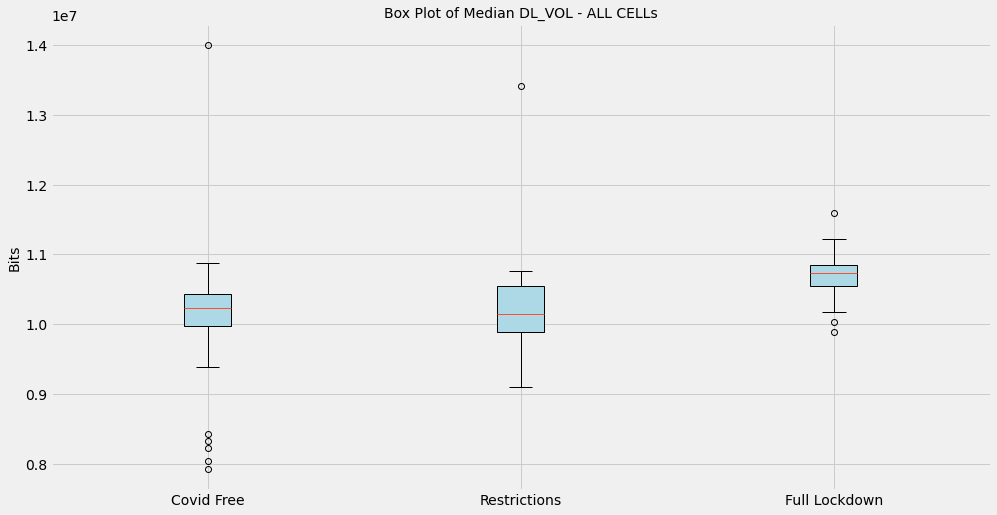


--------- Covid Free DL_VOL ---------
Median value: 10228299.84
Average value: 10098197.62
Standard deviation: 897092.93
--------- Restrictions DL_VOL ---------
Median value: 10155150.32
Average value: 10218866.57
Standard deviation: 820310.10
--------- Full Lockdown DL_VOL ---------
Median value: 10736376.01
Average value: 10692283.22
Standard deviation: 380883.26
>>>------ Covid Free DL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.72%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.19%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -8.56%
>>>------ Covid Free DL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.97%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 5.88%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -57.54%
>>>------ Restrictions DL_VOL Variation ------<<<
Median: difference between [ Restriction

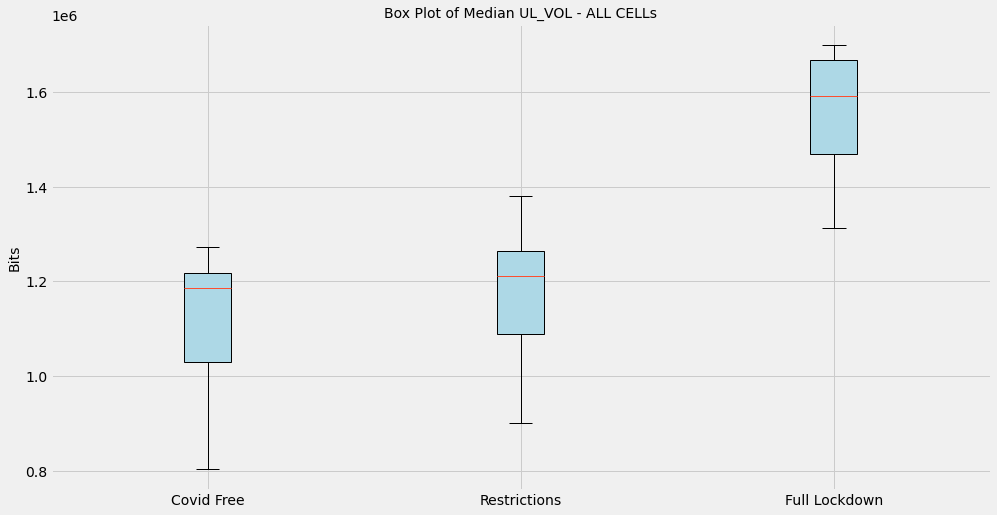


--------- Covid Free UL_VOL ---------
Median value: 1185227.90
Average value: 1119706.01
Standard deviation: 130533.09
--------- Restrictions UL_VOL ---------
Median value: 1211847.29
Average value: 1168873.07
Standard deviation: 132182.07
--------- Full Lockdown UL_VOL ---------
Median value: 1592944.30
Average value: 1562048.34
Standard deviation: 117307.45
>>>------ Covid Free UL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 2.25%
Average: difference between [ Covid Free ] and [ Restrictions ]: 4.39%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 1.26%
>>>------ Covid Free UL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 34.40%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 39.51%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -10.13%
>>>------ Restrictions UL_VOL Variation ------<<<
Median: difference between [ Restrictions ] an

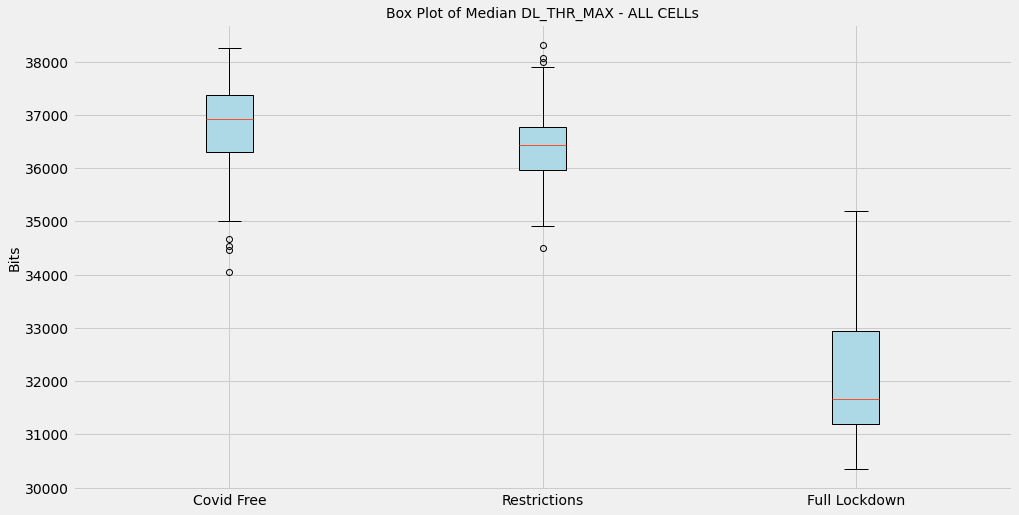


--------- Covid Free DL_THR_MAX ---------
Median value: 36921.34
Average value: 36688.49
Standard deviation: 962.73
--------- Restrictions DL_THR_MAX ---------
Median value: 36431.24
Average value: 36451.33
Standard deviation: 952.23
--------- Full Lockdown DL_THR_MAX ---------
Median value: 31657.86
Average value: 32185.83
Standard deviation: 1308.02
>>>------ Covid Free DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -1.33%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.65%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -1.09%
>>>------ Covid Free DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -14.26%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -12.27%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 35.87%
>>>------ Restrictions DL_THR_MAX Variation ------<<<
Median: difference between [ Restricti

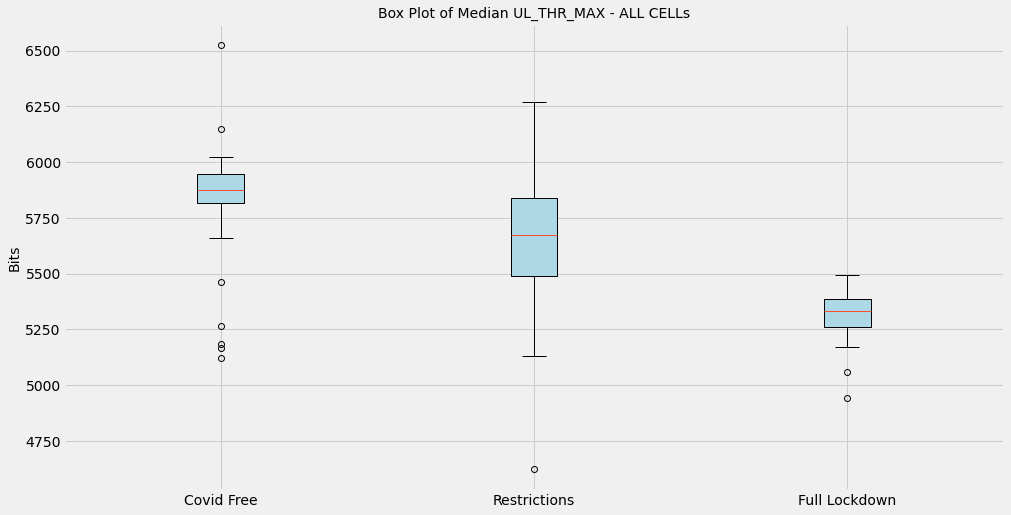


--------- Covid Free UL_THR_MAX ---------
Median value: 5875.97
Average value: 5832.88
Standard deviation: 242.88
--------- Restrictions UL_THR_MAX ---------
Median value: 5674.36
Average value: 5662.31
Standard deviation: 378.19
--------- Full Lockdown UL_THR_MAX ---------
Median value: 5333.43
Average value: 5303.49
Standard deviation: 128.26
>>>------ Covid Free UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -3.43%
Average: difference between [ Covid Free ] and [ Restrictions ]: -2.92%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 55.71%
>>>------ Covid Free UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -9.23%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -9.08%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -47.19%
>>>------ Restrictions UL_THR_MAX Variation ------<<<
Median: difference between [ Restrictions ] an

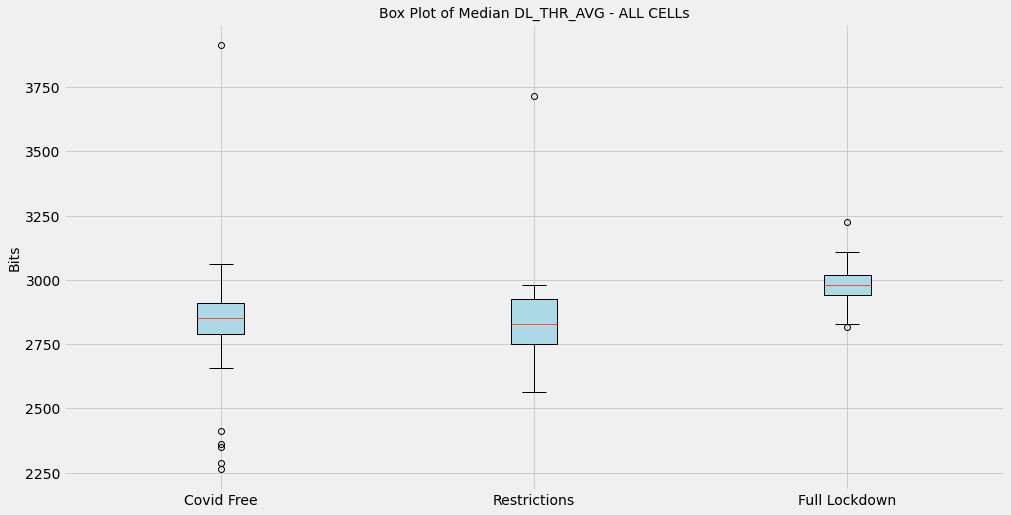


--------- Covid Free DL_THR_AVG ---------
Median value: 2851.08
Average value: 2822.99
Standard deviation: 239.82
--------- Restrictions DL_THR_AVG ---------
Median value: 2829.85
Average value: 2846.64
Standard deviation: 218.02
--------- Full Lockdown DL_THR_AVG ---------
Median value: 2979.95
Average value: 2982.10
Standard deviation: 90.86
>>>------ Covid Free DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.74%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -9.09%
>>>------ Covid Free DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.52%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 5.64%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -62.11%
>>>------ Restrictions DL_THR_AVG Variation ------<<<
Median: difference between [ Restrictions ] and [ 

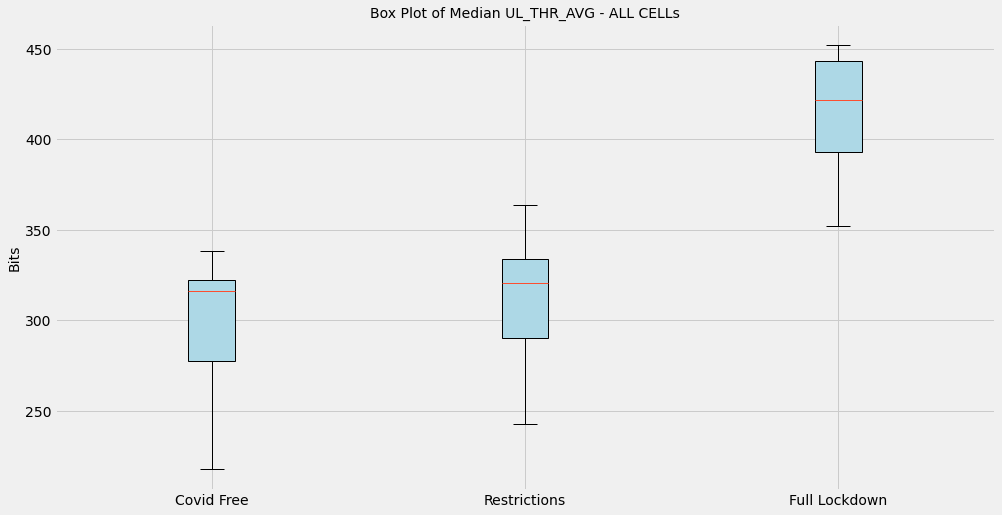


--------- Covid Free UL_THR_AVG ---------
Median value: 316.21
Average value: 298.66
Standard deviation: 32.52
--------- Restrictions UL_THR_AVG ---------
Median value: 320.31
Average value: 310.13
Standard deviation: 33.48
--------- Full Lockdown UL_THR_AVG ---------
Median value: 421.88
Average value: 416.74
Standard deviation: 29.52
>>>------ Covid Free UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 1.30%
Average: difference between [ Covid Free ] and [ Restrictions ]: 3.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 2.96%
>>>------ Covid Free UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 33.41%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 39.54%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -9.23%
>>>------ Restrictions UL_THR_AVG Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lock

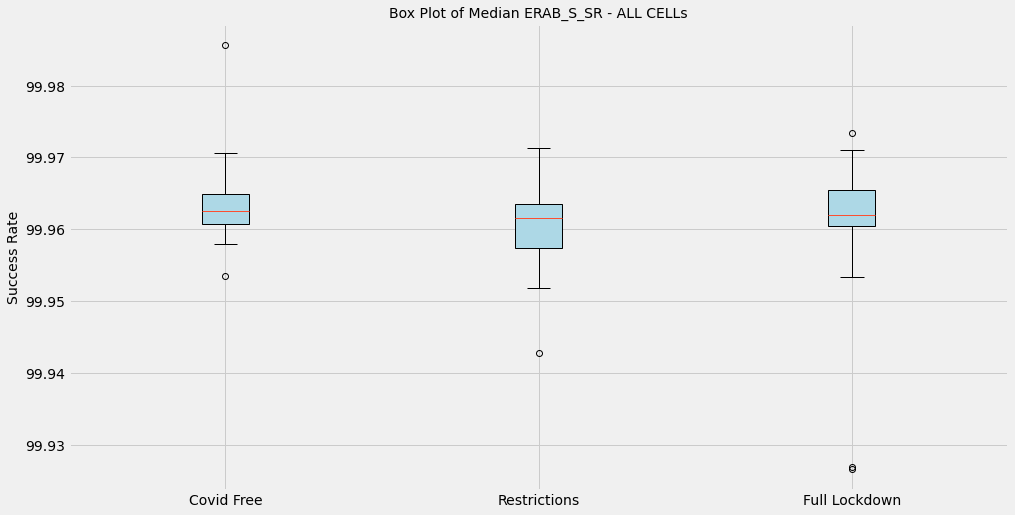


--------- Covid Free ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.00
--------- Restrictions ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
>>>------ Covid Free ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.00%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.00%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 29.56%
>>>------ Covid Free ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.00%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.00%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 136.08%
>>>------ Restrictions ERAB_S_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: 0.0

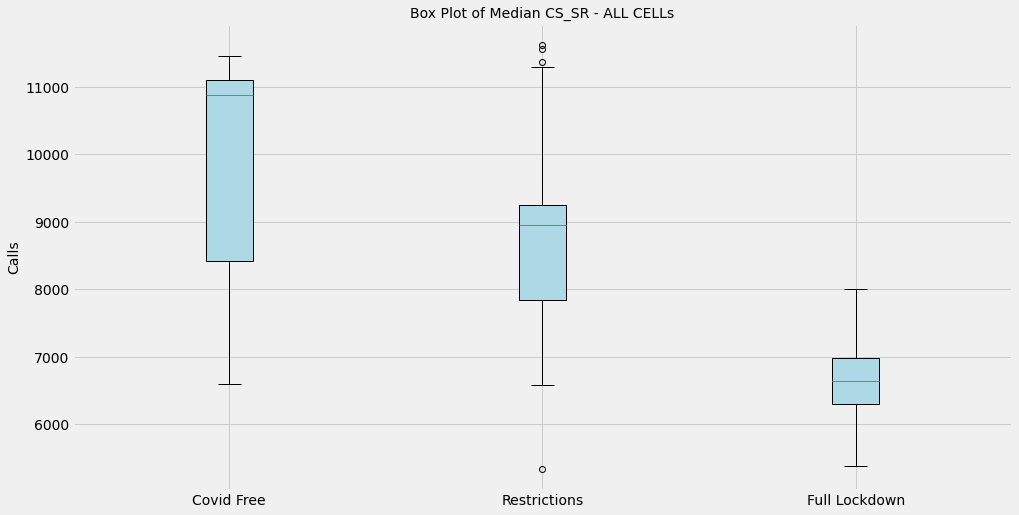


--------- Covid Free CS_SR ---------
Median value: 10881.89
Average value: 9870.74
Standard deviation: 1529.75
--------- Restrictions CS_SR ---------
Median value: 8950.49
Average value: 8801.19
Standard deviation: 1643.62
--------- Full Lockdown CS_SR ---------
Median value: 6640.26
Average value: 6731.95
Standard deviation: 633.76
>>>------ Covid Free CS_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -17.75%
Average: difference between [ Covid Free ] and [ Restrictions ]: -10.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 7.44%
>>>------ Covid Free CS_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -38.98%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -31.80%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -58.57%
>>>------ Restrictions CS_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -25

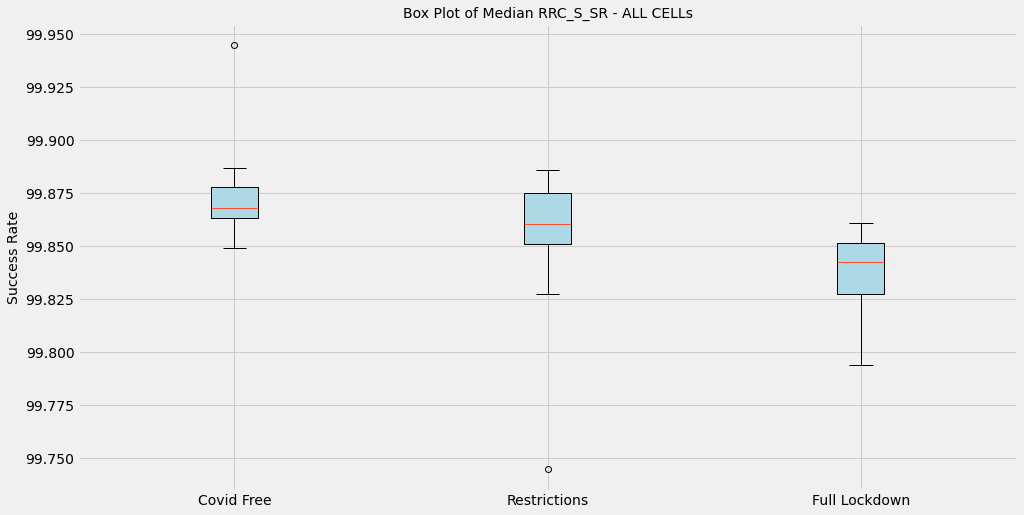


--------- Covid Free RRC_S_SR ---------
Median value: 99.87
Average value: 99.87
Standard deviation: 0.01
--------- Restrictions RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.03
--------- Full Lockdown RRC_S_SR ---------
Median value: 99.84
Average value: 99.84
Standard deviation: 0.02
>>>------ Covid Free RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.01%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.01%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 99.34%
>>>------ Covid Free RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.03%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.03%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 31.34%
>>>------ Restrictions RRC_S_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -0.02%
Ave

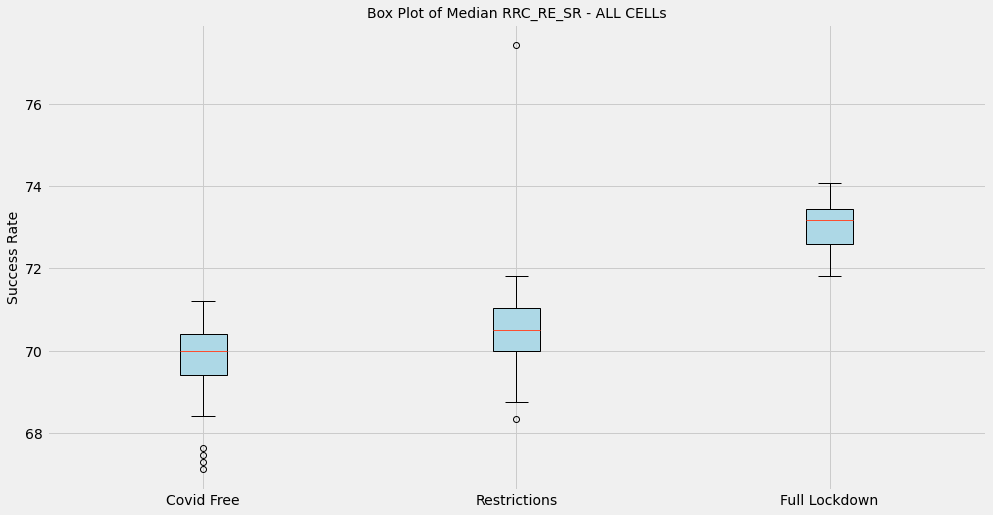


--------- Covid Free RRC_RE_SR ---------
Median value: 69.99
Average value: 69.77
Standard deviation: 0.95
--------- Restrictions RRC_RE_SR ---------
Median value: 70.50
Average value: 70.67
Standard deviation: 1.63
--------- Full Lockdown RRC_RE_SR ---------
Median value: 73.17
Average value: 73.05
Standard deviation: 0.60
>>>------ Covid Free RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.73%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.28%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 71.04%
>>>------ Covid Free RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.54%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 4.70%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -37.29%
>>>------ Restrictions RRC_RE_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: 3.79%
A

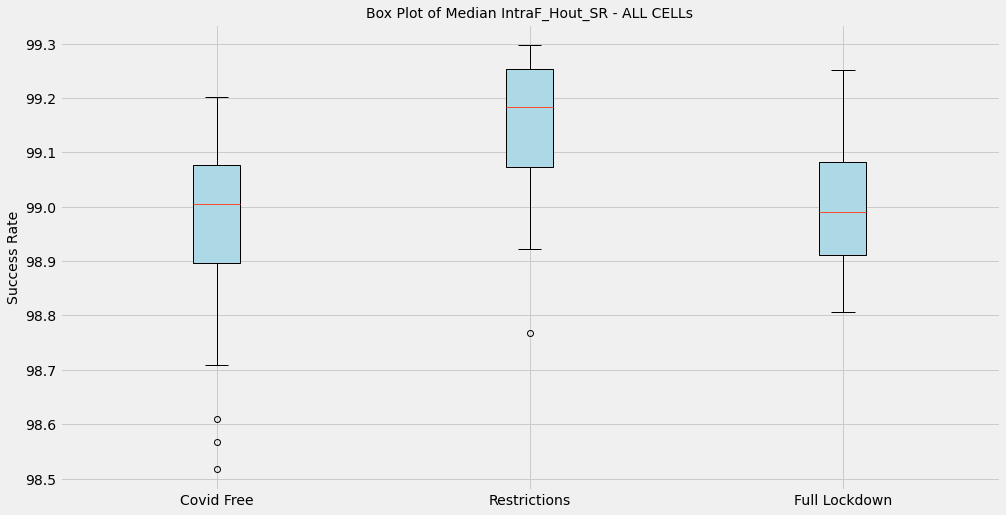


--------- Covid Free IntraF_Hout_SR ---------
Median value: 99.01
Average value: 98.97
Standard deviation: 0.16
--------- Restrictions IntraF_Hout_SR ---------
Median value: 99.18
Average value: 99.15
Standard deviation: 0.13
--------- Full Lockdown IntraF_Hout_SR ---------
Median value: 98.99
Average value: 99.00
Standard deviation: 0.12
>>>------ Covid Free IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.18%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.18%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -20.25%
>>>------ Covid Free IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.02%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 0.03%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -28.06%
>>>------ Restrictions IntraF_Hout_SR Variation ------<<<
Median: difference between [ Restrictions 

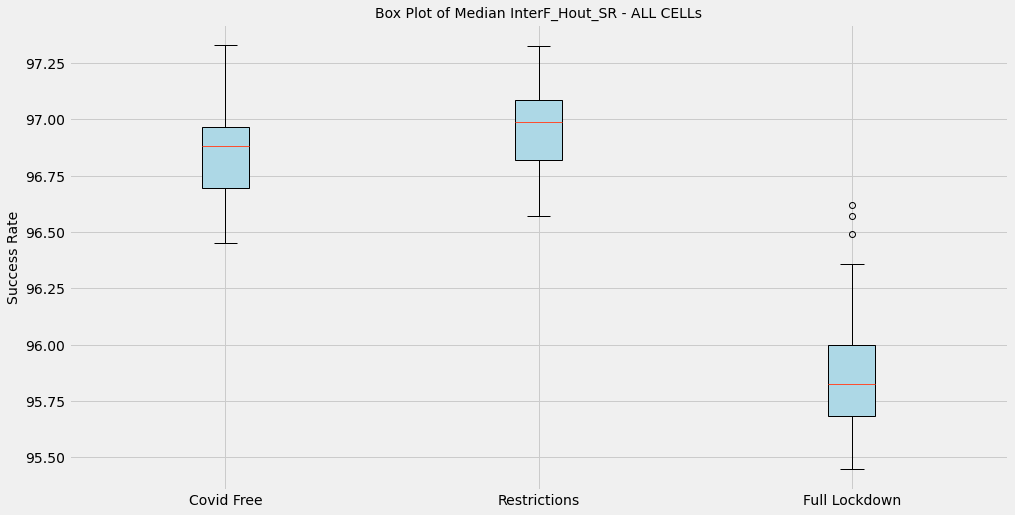


--------- Covid Free InterF_Hout_SR ---------
Median value: 96.88
Average value: 96.85
Standard deviation: 0.21
--------- Restrictions InterF_Hout_SR ---------
Median value: 96.99
Average value: 96.97
Standard deviation: 0.20
--------- Full Lockdown InterF_Hout_SR ---------
Median value: 95.82
Average value: 95.91
Standard deviation: 0.32
>>>------ Covid Free InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.11%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.12%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -4.99%
>>>------ Covid Free InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -1.09%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.97%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 52.92%
>>>------ Restrictions InterF_Hout_SR Variation ------<<<
Median: difference between [ Restrictions ]

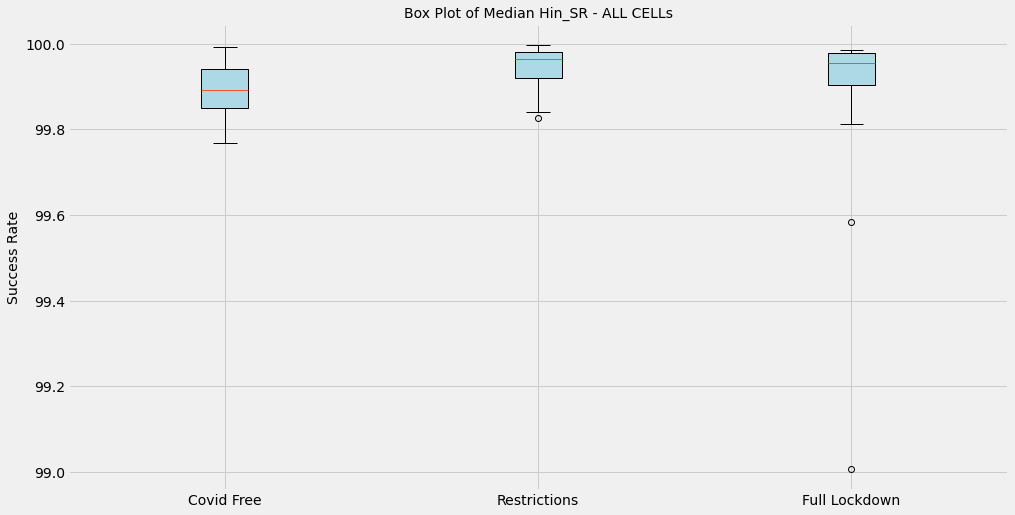


--------- Covid Free Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- Restrictions Hin_SR ---------
Median value: 99.96
Average value: 99.94
Standard deviation: 0.05
--------- Full Lockdown Hin_SR ---------
Median value: 99.95
Average value: 99.88
Standard deviation: 0.21
>>>------ Covid Free Hin_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.07%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.05%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -13.86%
>>>------ Covid Free Hin_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 0.06%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.01%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 258.46%
>>>------ Restrictions Hin_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -0.01%
Average: differe

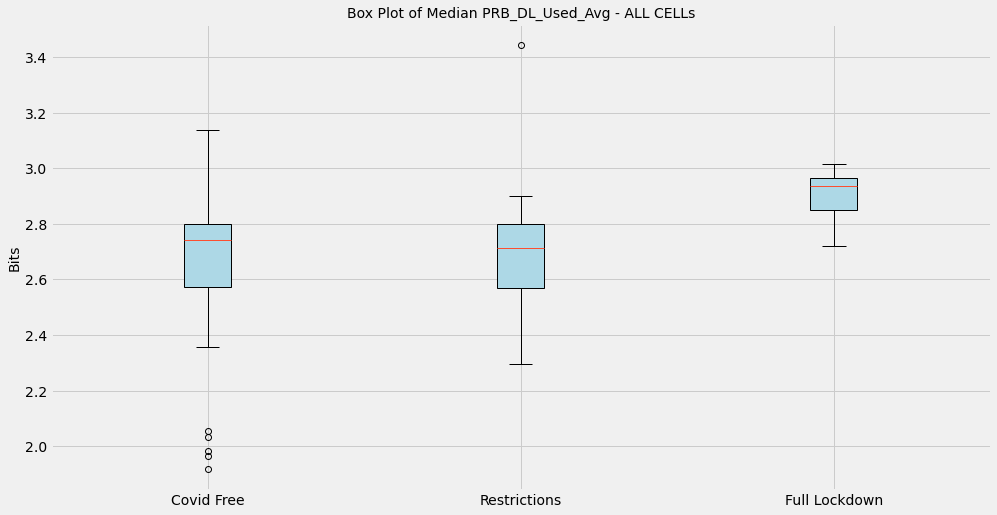


--------- Covid Free PRB_DL_Used_Avg ---------
Median value: 2.74
Average value: 2.64
Standard deviation: 0.26
--------- Restrictions PRB_DL_Used_Avg ---------
Median value: 2.71
Average value: 2.69
Standard deviation: 0.23
--------- Full Lockdown PRB_DL_Used_Avg ---------
Median value: 2.94
Average value: 2.90
Standard deviation: 0.09
>>>------ Covid Free PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -1.02%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -11.47%
>>>------ Covid Free PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 7.09%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 9.77%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -65.73%
>>>------ Restrictions PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Restrictions 

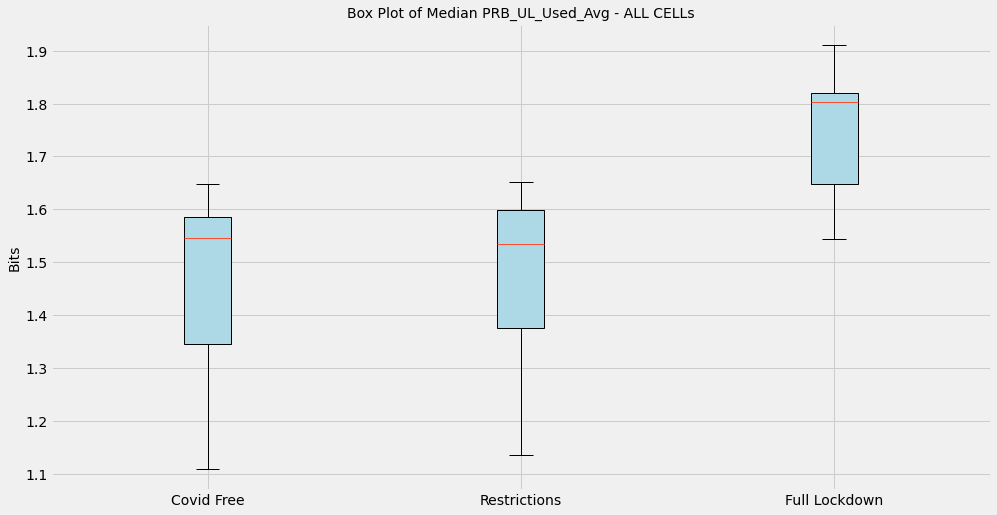


--------- Covid Free PRB_UL_Used_Avg ---------
Median value: 1.55
Average value: 1.46
Standard deviation: 0.16
--------- Restrictions PRB_UL_Used_Avg ---------
Median value: 1.53
Average value: 1.47
Standard deviation: 0.16
--------- Full Lockdown PRB_UL_Used_Avg ---------
Median value: 1.80
Average value: 1.75
Standard deviation: 0.11
>>>------ Covid Free PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.71%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.81%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 2.24%
>>>------ Covid Free PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 16.70%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 19.93%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -31.54%
>>>------ Restrictions PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Restrictions 

In [109]:
periods = [covid_free, restrictions, full_lockdown]
plot_stats(periods, periods_lables)

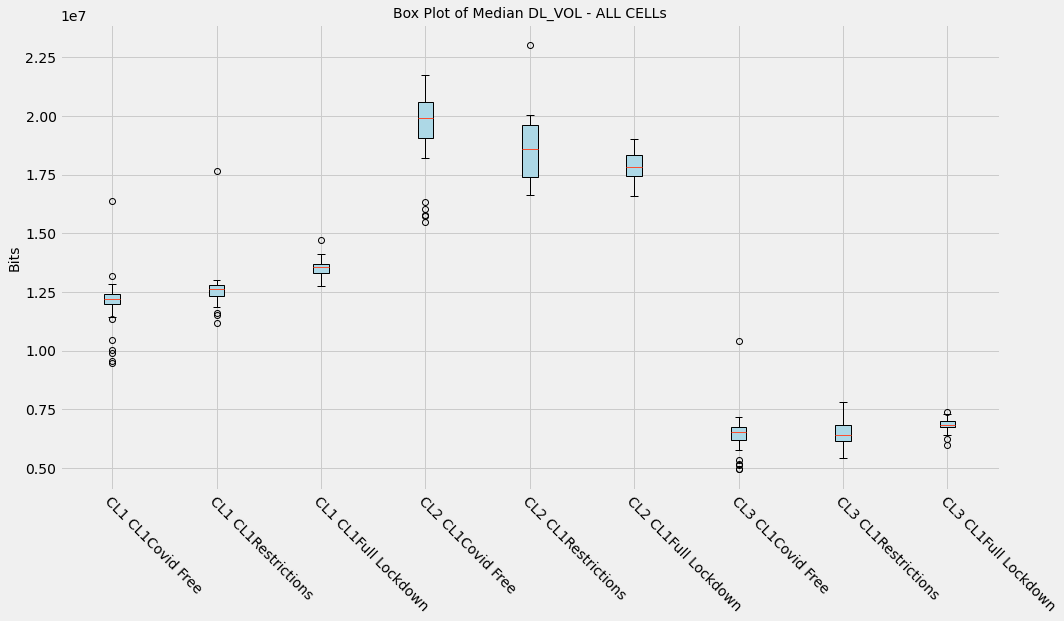


--------- CL1 CL1Covid Free DL_VOL ---------
Median value: 12203941.61
Average value: 12064829.17
Standard deviation: 1022164.72
--------- CL1 CL1Restrictions DL_VOL ---------
Median value: 12629167.16
Average value: 12652893.63
Standard deviation: 1140492.39
--------- CL1 CL1Full Lockdown DL_VOL ---------
Median value: 13585264.28
Average value: 13520003.72
Standard deviation: 448983.75
--------- CL2 CL1Covid Free DL_VOL ---------
Median value: 19893931.85
Average value: 19602493.25
Standard deviation: 1556308.78
--------- CL2 CL1Restrictions DL_VOL ---------
Median value: 18571781.00
Average value: 18581074.30
Standard deviation: 1389433.84
--------- CL2 CL1Full Lockdown DL_VOL ---------
Median value: 17822880.78
Average value: 17834562.80
Standard deviation: 698083.94
--------- CL3 CL1Covid Free DL_VOL ---------
Median value: 6527226.71
Average value: 6467114.35
Standard deviation: 787622.00
--------- CL3 CL1Restrictions DL_VOL ---------
Median value: 6418769.10
Average value: 6476

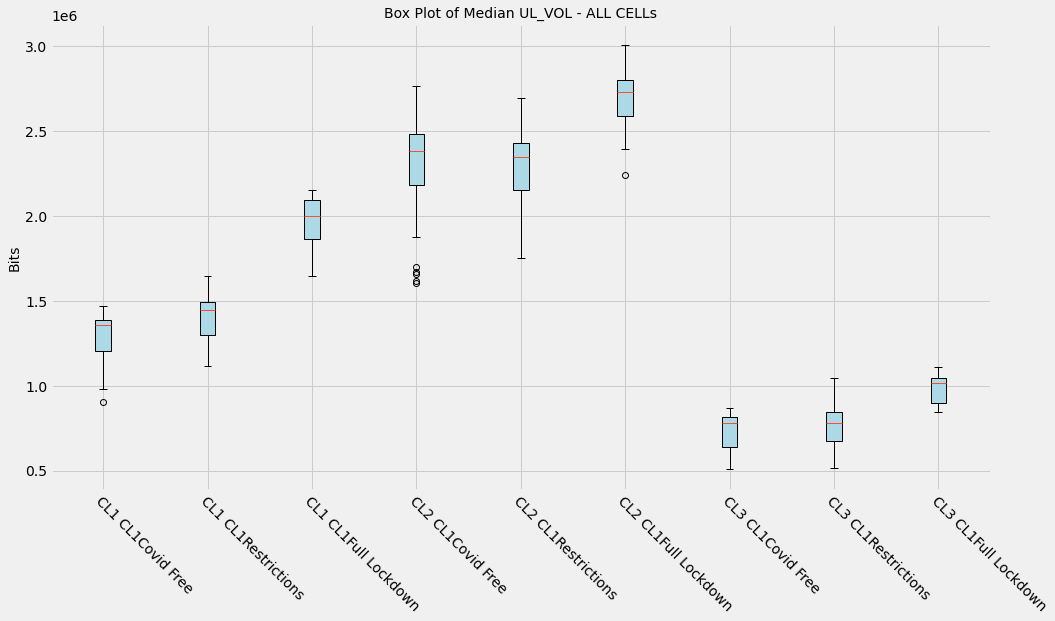


--------- CL1 CL1Covid Free UL_VOL ---------
Median value: 1357850.27
Average value: 1293570.99
Standard deviation: 137170.84
--------- CL1 CL1Restrictions UL_VOL ---------
Median value: 1446571.99
Average value: 1398781.34
Standard deviation: 139789.63
--------- CL1 CL1Full Lockdown UL_VOL ---------
Median value: 1998740.52
Average value: 1970341.61
Standard deviation: 148904.92
--------- CL2 CL1Covid Free UL_VOL ---------
Median value: 2384208.93
Average value: 2299338.43
Standard deviation: 279098.50
--------- CL2 CL1Restrictions UL_VOL ---------
Median value: 2348810.30
Average value: 2274520.59
Standard deviation: 257447.52
--------- CL2 CL1Full Lockdown UL_VOL ---------
Median value: 2731651.98
Average value: 2680751.25
Standard deviation: 175608.53
--------- CL3 CL1Covid Free UL_VOL ---------
Median value: 779760.91
Average value: 732753.76
Standard deviation: 107282.42
--------- CL3 CL1Restrictions UL_VOL ---------
Median value: 779722.17
Average value: 757218.92
Standard devi

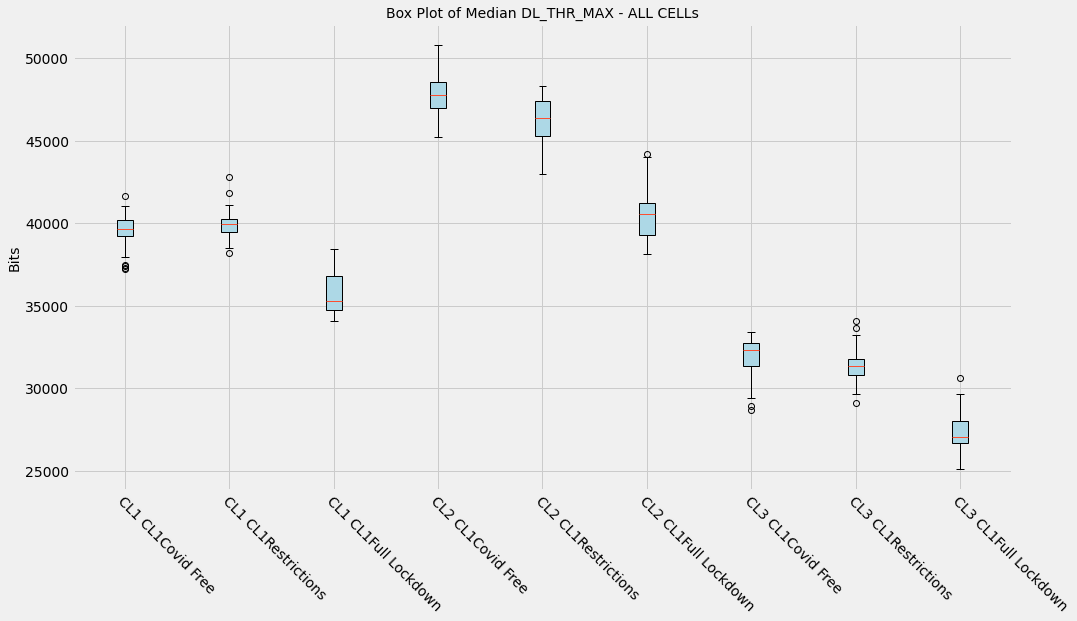


--------- CL1 CL1Covid Free DL_THR_MAX ---------
Median value: 39665.57
Average value: 39600.43
Standard deviation: 983.19
--------- CL1 CL1Restrictions DL_THR_MAX ---------
Median value: 39927.89
Average value: 40012.37
Standard deviation: 995.41
--------- CL1 CL1Full Lockdown DL_THR_MAX ---------
Median value: 35282.04
Average value: 35705.55
Standard deviation: 1265.16
--------- CL2 CL1Covid Free DL_THR_MAX ---------
Median value: 47746.04
Average value: 47851.25
Standard deviation: 1252.36
--------- CL2 CL1Restrictions DL_THR_MAX ---------
Median value: 46388.68
Average value: 46307.86
Standard deviation: 1316.68
--------- CL2 CL1Full Lockdown DL_THR_MAX ---------
Median value: 40546.93
Average value: 40592.76
Standard deviation: 1708.88
--------- CL3 CL1Covid Free DL_THR_MAX ---------
Median value: 32312.56
Average value: 31879.22
Standard deviation: 1185.66
--------- CL3 CL1Restrictions DL_THR_MAX ---------
Median value: 31332.89
Average value: 31416.81
Standard deviation: 1190.

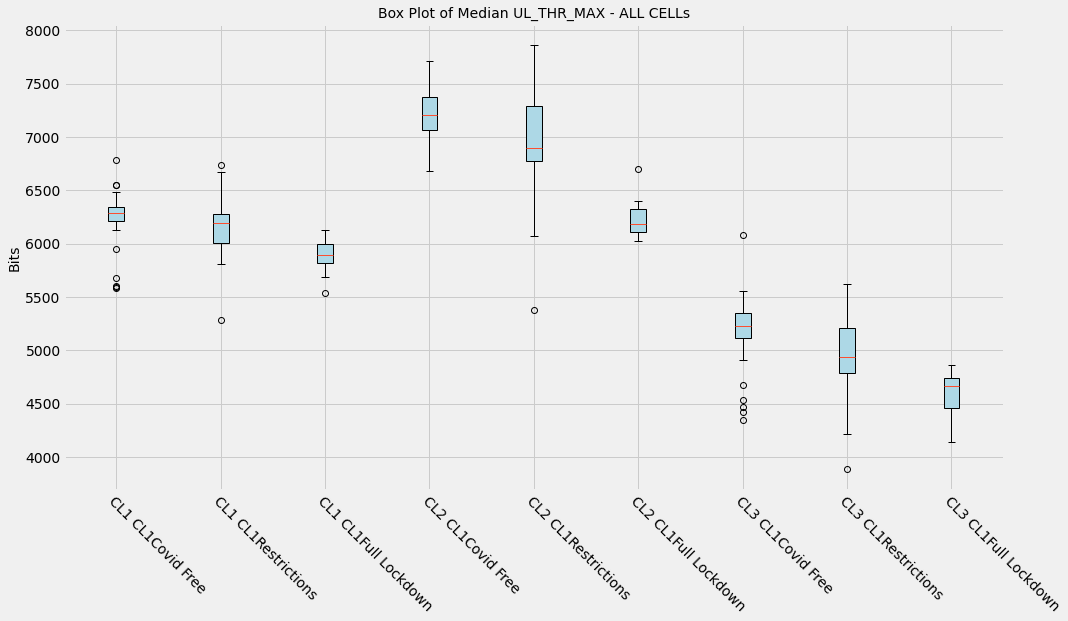


--------- CL1 CL1Covid Free UL_THR_MAX ---------
Median value: 6290.80
Average value: 6250.62
Standard deviation: 229.73
--------- CL1 CL1Restrictions UL_THR_MAX ---------
Median value: 6193.74
Average value: 6181.58
Standard deviation: 320.86
--------- CL1 CL1Full Lockdown UL_THR_MAX ---------
Median value: 5888.68
Average value: 5892.01
Standard deviation: 133.76
--------- CL2 CL1Covid Free UL_THR_MAX ---------
Median value: 7205.62
Average value: 7208.86
Standard deviation: 251.15
--------- CL2 CL1Restrictions UL_THR_MAX ---------
Median value: 6895.06
Average value: 6963.86
Standard deviation: 517.99
--------- CL2 CL1Full Lockdown UL_THR_MAX ---------
Median value: 6179.57
Average value: 6227.19
Standard deviation: 151.64
--------- CL3 CL1Covid Free UL_THR_MAX ---------
Median value: 5229.60
Average value: 5186.52
Standard deviation: 308.65
--------- CL3 CL1Restrictions UL_THR_MAX ---------
Median value: 4934.47
Average value: 4952.94
Standard deviation: 427.51
--------- CL3 CL1Fu

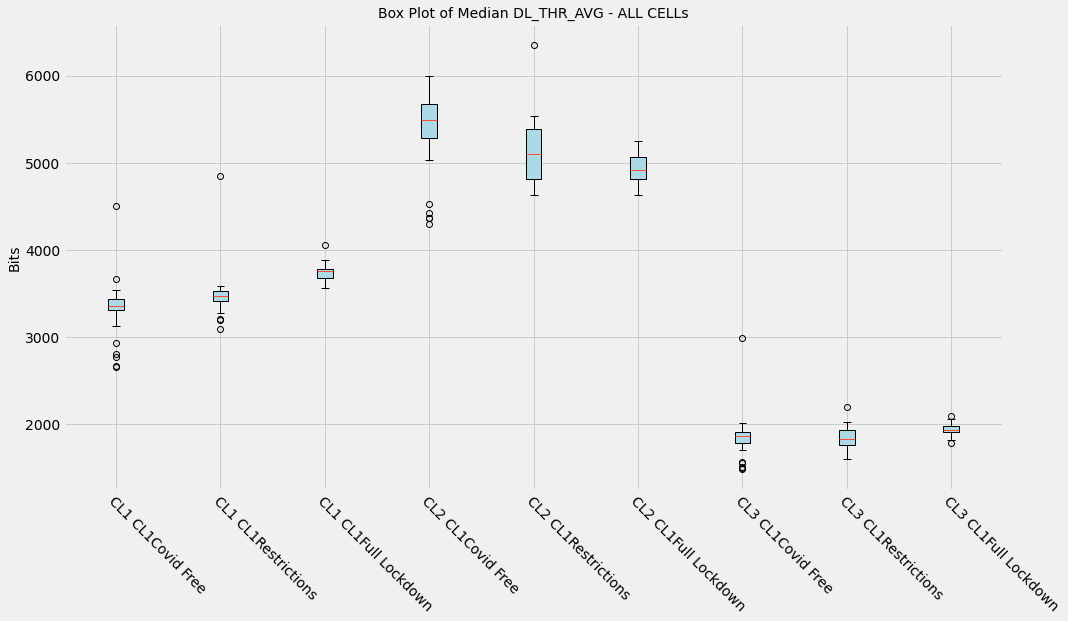


--------- CL1 CL1Covid Free DL_THR_AVG ---------
Median value: 3354.06
Average value: 3336.52
Standard deviation: 273.41
--------- CL1 CL1Restrictions DL_THR_AVG ---------
Median value: 3469.11
Average value: 3491.68
Standard deviation: 308.09
--------- CL1 CL1Full Lockdown DL_THR_AVG ---------
Median value: 3753.30
Average value: 3739.62
Standard deviation: 110.85
--------- CL2 CL1Covid Free DL_THR_AVG ---------
Median value: 5492.70
Average value: 5409.71
Standard deviation: 422.54
--------- CL2 CL1Restrictions DL_THR_AVG ---------
Median value: 5104.51
Average value: 5120.93
Standard deviation: 375.50
--------- CL2 CL1Full Lockdown DL_THR_AVG ---------
Median value: 4920.37
Average value: 4930.95
Standard deviation: 173.81
--------- CL3 CL1Covid Free DL_THR_AVG ---------
Median value: 1865.59
Average value: 1854.34
Standard deviation: 209.72
--------- CL3 CL1Restrictions DL_THR_AVG ---------
Median value: 1833.64
Average value: 1844.20
Standard deviation: 140.41
--------- CL3 CL1Fu

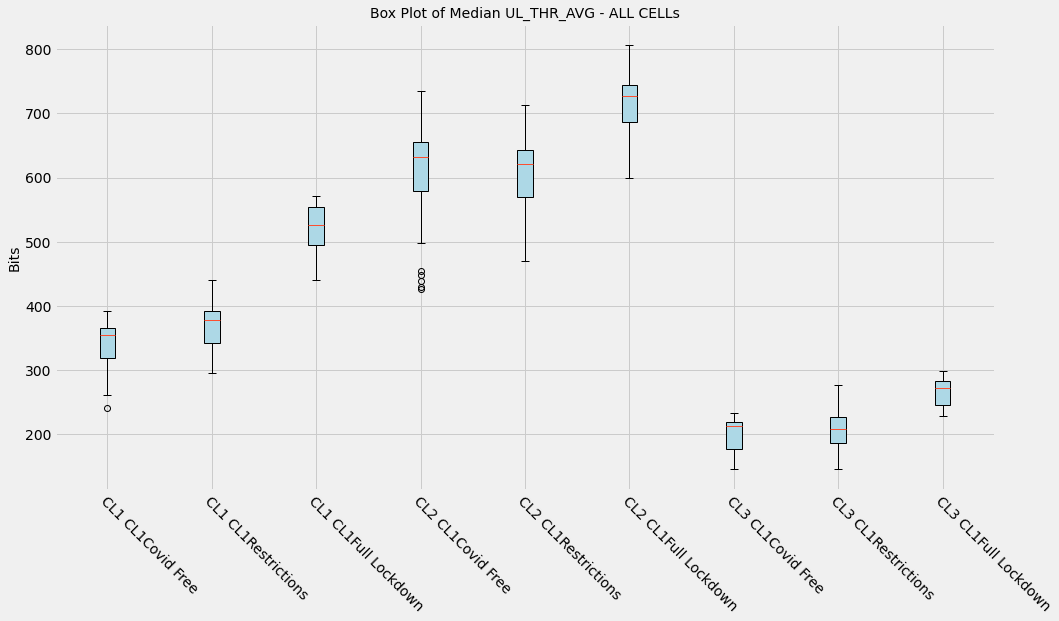


--------- CL1 CL1Covid Free UL_THR_AVG ---------
Median value: 354.36
Average value: 340.96
Standard deviation: 34.94
--------- CL1 CL1Restrictions UL_THR_AVG ---------
Median value: 378.74
Average value: 367.94
Standard deviation: 36.56
--------- CL1 CL1Full Lockdown UL_THR_AVG ---------
Median value: 525.91
Average value: 521.62
Standard deviation: 37.64
--------- CL2 CL1Covid Free UL_THR_AVG ---------
Median value: 632.41
Average value: 609.22
Standard deviation: 72.87
--------- CL2 CL1Restrictions UL_THR_AVG ---------
Median value: 620.40
Average value: 601.80
Standard deviation: 67.29
--------- CL2 CL1Full Lockdown UL_THR_AVG ---------
Median value: 727.34
Average value: 714.75
Standard deviation: 45.11
--------- CL3 CL1Covid Free UL_THR_AVG ---------
Median value: 213.29
Average value: 199.93
Standard deviation: 25.80
--------- CL3 CL1Restrictions UL_THR_AVG ---------
Median value: 208.26
Average value: 204.12
Standard deviation: 30.28
--------- CL3 CL1Full Lockdown UL_THR_AVG -

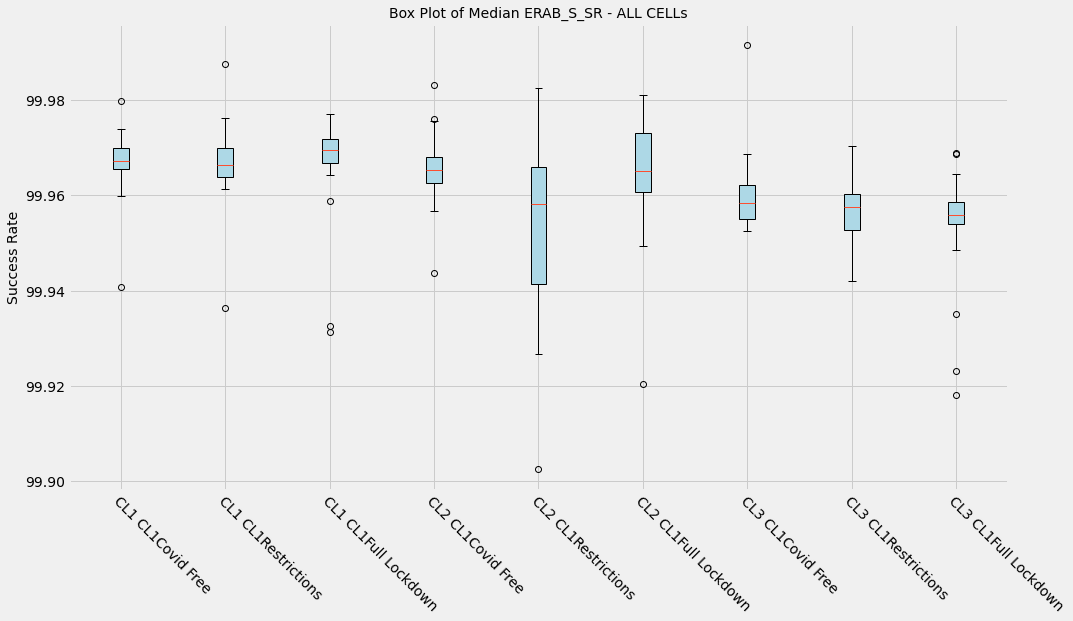


--------- CL1 CL1Covid Free ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- CL1 CL1Restrictions ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- CL1 CL1Full Lockdown ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- CL2 CL1Covid Free ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- CL2 CL1Restrictions ERAB_S_SR ---------
Median value: 99.96
Average value: 99.95
Standard deviation: 0.02
--------- CL2 CL1Full Lockdown ERAB_S_SR ---------
Median value: 99.97
Average value: 99.96
Standard deviation: 0.01
--------- CL3 CL1Covid Free ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- CL3 CL1Restrictions ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- CL3 CL1Full Lockdown ERAB_S_SR ---------
Median value: 99.96
Aver

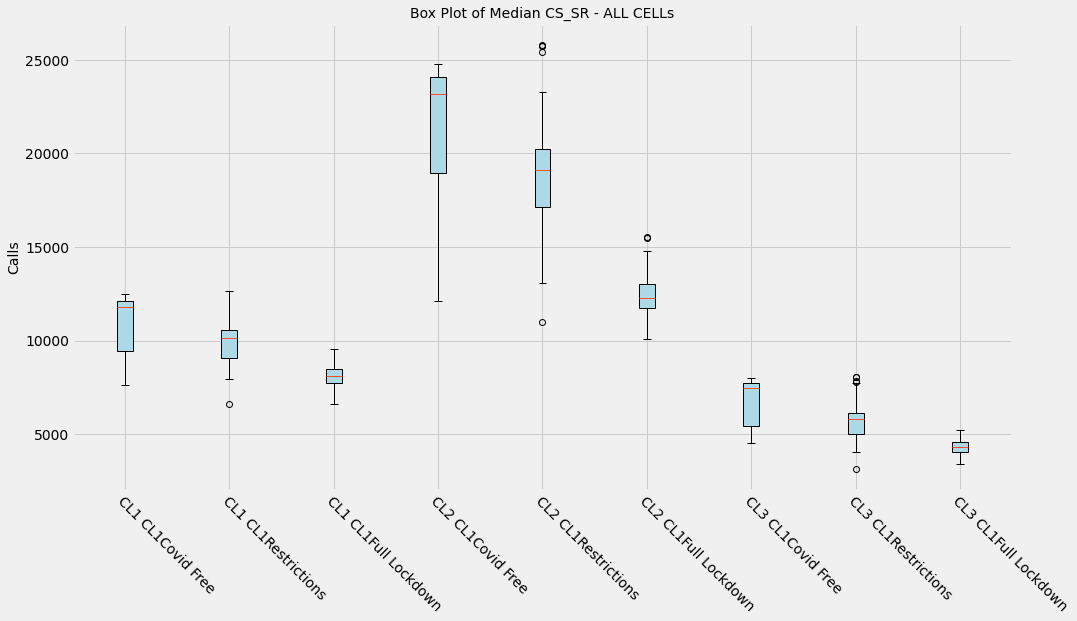


--------- CL1 CL1Covid Free CS_SR ---------
Median value: 11782.95
Average value: 10865.77
Standard deviation: 1544.39
--------- CL1 CL1Restrictions CS_SR ---------
Median value: 10152.91
Average value: 10031.38
Standard deviation: 1545.04
--------- CL1 CL1Full Lockdown CS_SR ---------
Median value: 8086.13
Average value: 8169.92
Standard deviation: 707.48
--------- CL2 CL1Covid Free CS_SR ---------
Median value: 23180.46
Average value: 21437.25
Standard deviation: 3428.56
--------- CL2 CL1Restrictions CS_SR ---------
Median value: 19091.02
Average value: 19106.76
Standard deviation: 3914.01
--------- CL2 CL1Full Lockdown CS_SR ---------
Median value: 12294.00
Average value: 12659.32
Standard deviation: 1360.57
--------- CL3 CL1Covid Free CS_SR ---------
Median value: 7485.76
Average value: 6712.31
Standard deviation: 1196.15
--------- CL3 CL1Restrictions CS_SR ---------
Median value: 5832.28
Average value: 5789.52
Standard deviation: 1328.56
--------- CL3 CL1Full Lockdown CS_SR -----

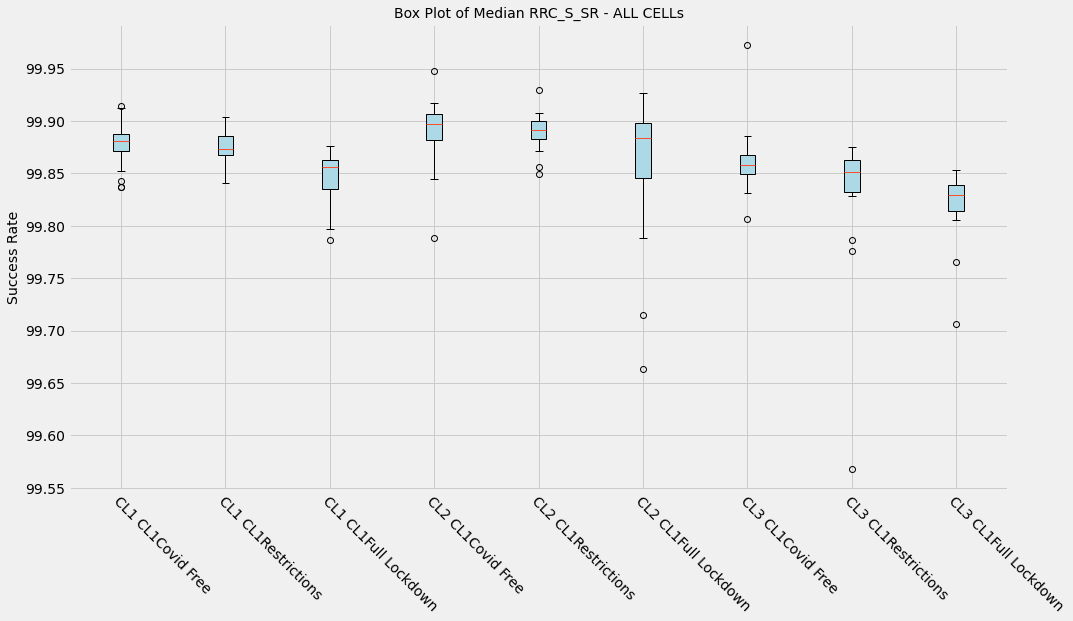


--------- CL1 CL1Covid Free RRC_S_SR ---------
Median value: 99.88
Average value: 99.88
Standard deviation: 0.02
--------- CL1 CL1Restrictions RRC_S_SR ---------
Median value: 99.87
Average value: 99.88
Standard deviation: 0.02
--------- CL1 CL1Full Lockdown RRC_S_SR ---------
Median value: 99.86
Average value: 99.85
Standard deviation: 0.02
--------- CL2 CL1Covid Free RRC_S_SR ---------
Median value: 99.90
Average value: 99.89
Standard deviation: 0.02
--------- CL2 CL1Restrictions RRC_S_SR ---------
Median value: 99.89
Average value: 99.89
Standard deviation: 0.02
--------- CL2 CL1Full Lockdown RRC_S_SR ---------
Median value: 99.88
Average value: 99.86
Standard deviation: 0.06
--------- CL3 CL1Covid Free RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.02
--------- CL3 CL1Restrictions RRC_S_SR ---------
Median value: 99.85
Average value: 99.83
Standard deviation: 0.06
--------- CL3 CL1Full Lockdown RRC_S_SR ---------
Median value: 99.83
Average value

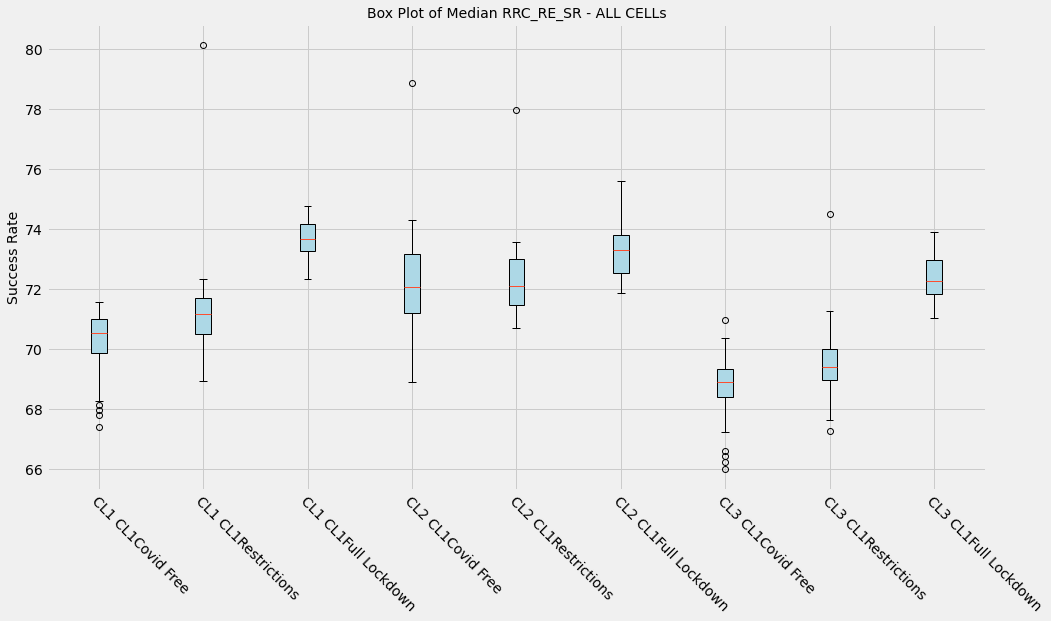


--------- CL1 CL1Covid Free RRC_RE_SR ---------
Median value: 70.53
Average value: 70.29
Standard deviation: 1.06
--------- CL1 CL1Restrictions RRC_RE_SR ---------
Median value: 71.16
Average value: 71.38
Standard deviation: 2.00
--------- CL1 CL1Full Lockdown RRC_RE_SR ---------
Median value: 73.66
Average value: 73.71
Standard deviation: 0.64
--------- CL2 CL1Covid Free RRC_RE_SR ---------
Median value: 72.06
Average value: 72.20
Standard deviation: 1.66
--------- CL2 CL1Restrictions RRC_RE_SR ---------
Median value: 72.11
Average value: 72.38
Standard deviation: 1.46
--------- CL2 CL1Full Lockdown RRC_RE_SR ---------
Median value: 73.30
Average value: 73.25
Standard deviation: 0.85
--------- CL3 CL1Covid Free RRC_RE_SR ---------
Median value: 68.91
Average value: 68.78
Standard deviation: 1.08
--------- CL3 CL1Restrictions RRC_RE_SR ---------
Median value: 69.40
Average value: 69.64
Standard deviation: 1.37
--------- CL3 CL1Full Lockdown RRC_RE_SR ---------
Median value: 72.27
Aver

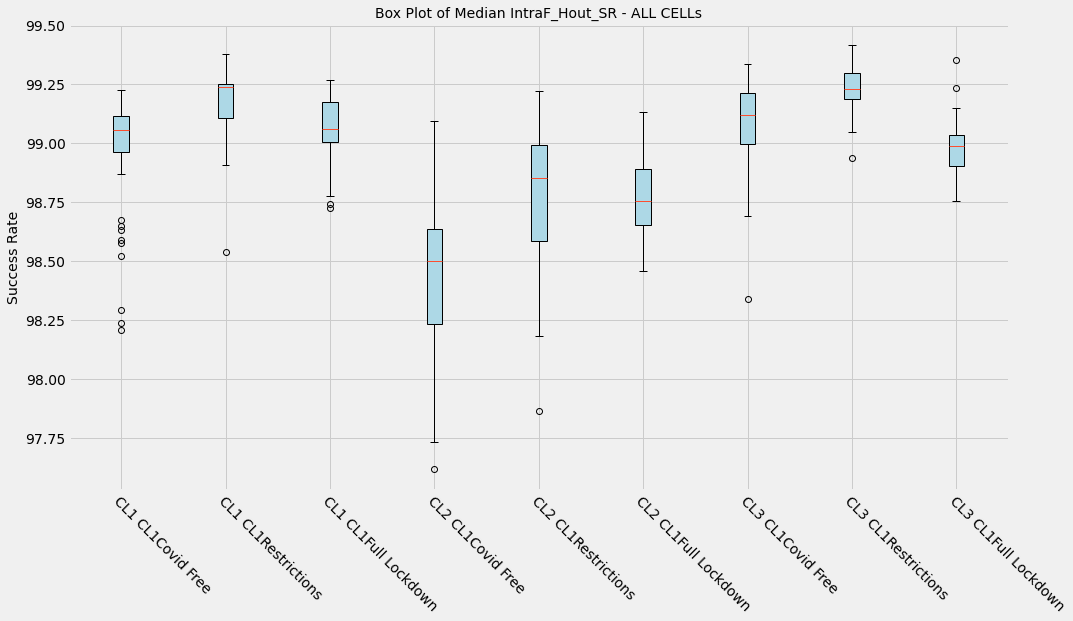


--------- CL1 CL1Covid Free IntraF_Hout_SR ---------
Median value: 99.05
Average value: 98.96
Standard deviation: 0.25
--------- CL1 CL1Restrictions IntraF_Hout_SR ---------
Median value: 99.24
Average value: 99.16
Standard deviation: 0.18
--------- CL1 CL1Full Lockdown IntraF_Hout_SR ---------
Median value: 99.06
Average value: 99.05
Standard deviation: 0.16
--------- CL2 CL1Covid Free IntraF_Hout_SR ---------
Median value: 98.50
Average value: 98.43
Standard deviation: 0.33
--------- CL2 CL1Restrictions IntraF_Hout_SR ---------
Median value: 98.85
Average value: 98.74
Standard deviation: 0.33
--------- CL2 CL1Full Lockdown IntraF_Hout_SR ---------
Median value: 98.76
Average value: 98.78
Standard deviation: 0.17
--------- CL3 CL1Covid Free IntraF_Hout_SR ---------
Median value: 99.12
Average value: 99.09
Standard deviation: 0.18
--------- CL3 CL1Restrictions IntraF_Hout_SR ---------
Median value: 99.23
Average value: 99.23
Standard deviation: 0.10
--------- CL3 CL1Full Lockdown Intr

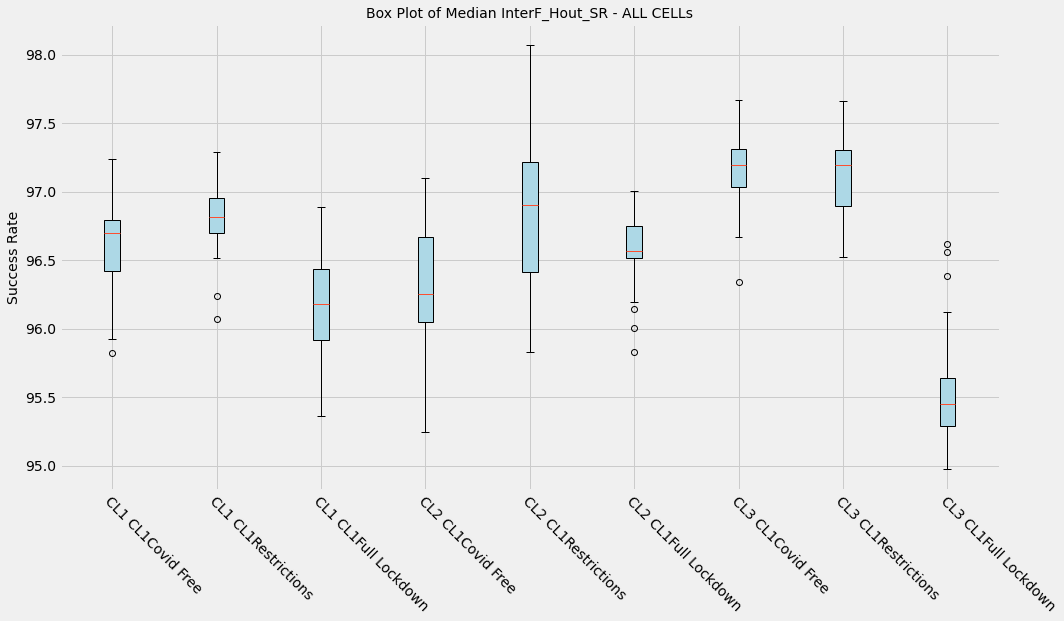


--------- CL1 CL1Covid Free InterF_Hout_SR ---------
Median value: 96.70
Average value: 96.62
Standard deviation: 0.31
--------- CL1 CL1Restrictions InterF_Hout_SR ---------
Median value: 96.81
Average value: 96.82
Standard deviation: 0.29
--------- CL1 CL1Full Lockdown InterF_Hout_SR ---------
Median value: 96.18
Average value: 96.17
Standard deviation: 0.37
--------- CL2 CL1Covid Free InterF_Hout_SR ---------
Median value: 96.25
Average value: 96.35
Standard deviation: 0.43
--------- CL2 CL1Restrictions InterF_Hout_SR ---------
Median value: 96.90
Average value: 96.85
Standard deviation: 0.53
--------- CL2 CL1Full Lockdown InterF_Hout_SR ---------
Median value: 96.56
Average value: 96.56
Standard deviation: 0.29
--------- CL3 CL1Covid Free InterF_Hout_SR ---------
Median value: 97.20
Average value: 97.17
Standard deviation: 0.26
--------- CL3 CL1Restrictions InterF_Hout_SR ---------
Median value: 97.19
Average value: 97.13
Standard deviation: 0.28
--------- CL3 CL1Full Lockdown Inte

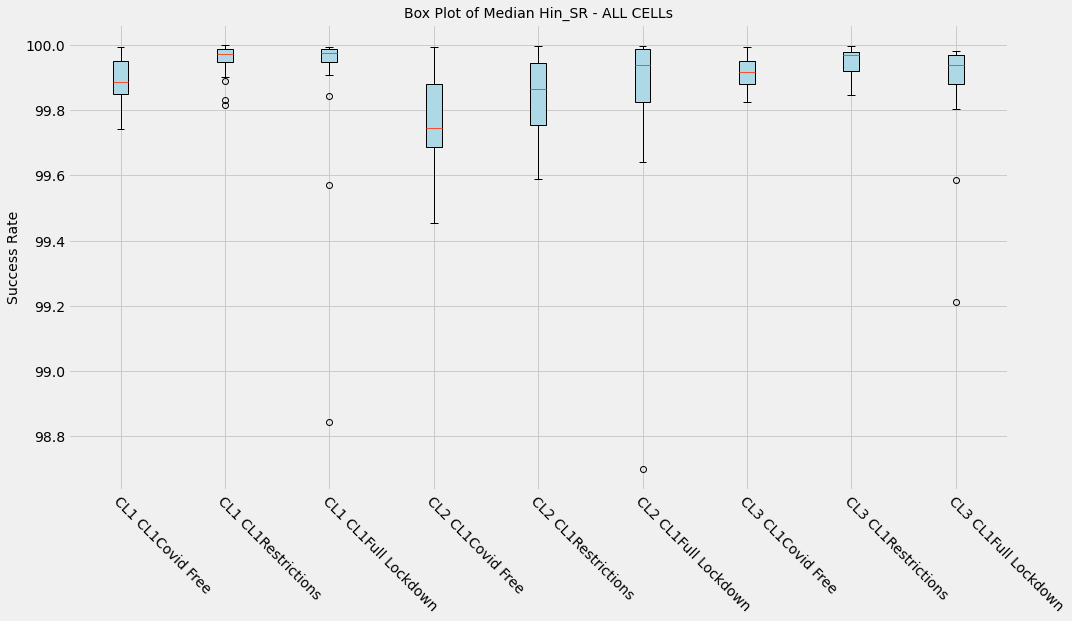


--------- CL1 CL1Covid Free Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- CL1 CL1Restrictions Hin_SR ---------
Median value: 99.97
Average value: 99.96
Standard deviation: 0.05
--------- CL1 CL1Full Lockdown Hin_SR ---------
Median value: 99.98
Average value: 99.90
Standard deviation: 0.25
--------- CL2 CL1Covid Free Hin_SR ---------
Median value: 99.74
Average value: 99.77
Standard deviation: 0.14
--------- CL2 CL1Restrictions Hin_SR ---------
Median value: 99.86
Average value: 99.84
Standard deviation: 0.13
--------- CL2 CL1Full Lockdown Hin_SR ---------
Median value: 99.94
Average value: 99.84
Standard deviation: 0.27
--------- CL3 CL1Covid Free Hin_SR ---------
Median value: 99.92
Average value: 99.92
Standard deviation: 0.05
--------- CL3 CL1Restrictions Hin_SR ---------
Median value: 99.97
Average value: 99.95
Standard deviation: 0.04
--------- CL3 CL1Full Lockdown Hin_SR ---------
Median value: 99.94
Average value: 99.88
Standard d

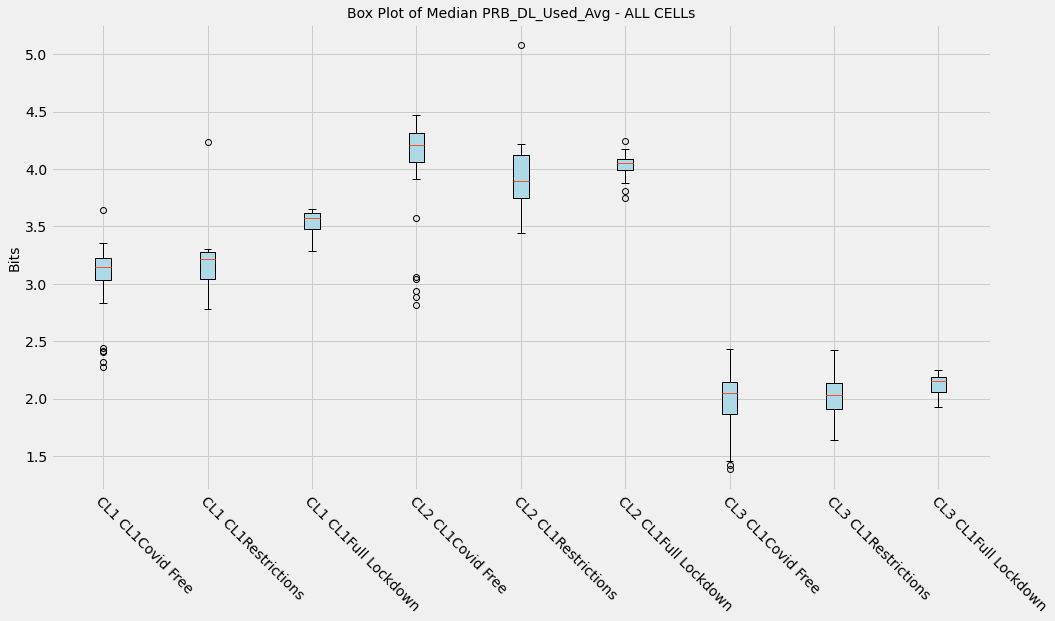


--------- CL1 CL1Covid Free PRB_DL_Used_Avg ---------
Median value: 3.14
Average value: 3.08
Standard deviation: 0.28
--------- CL1 CL1Restrictions PRB_DL_Used_Avg ---------
Median value: 3.21
Average value: 3.18
Standard deviation: 0.27
--------- CL1 CL1Full Lockdown PRB_DL_Used_Avg ---------
Median value: 3.57
Average value: 3.53
Standard deviation: 0.11
--------- CL2 CL1Covid Free PRB_DL_Used_Avg ---------
Median value: 4.21
Average value: 4.08
Standard deviation: 0.42
--------- CL2 CL1Restrictions PRB_DL_Used_Avg ---------
Median value: 3.89
Average value: 3.93
Standard deviation: 0.33
--------- CL2 CL1Full Lockdown PRB_DL_Used_Avg ---------
Median value: 4.06
Average value: 4.03
Standard deviation: 0.11
--------- CL3 CL1Covid Free PRB_DL_Used_Avg ---------
Median value: 2.05
Average value: 1.98
Standard deviation: 0.24
--------- CL3 CL1Restrictions PRB_DL_Used_Avg ---------
Median value: 2.04
Average value: 2.02
Standard deviation: 0.20
--------- CL3 CL1Full Lockdown PRB_DL_Used_

In [ ]:
periods = cl_periods_dataframes_list[0] + cl_periods_dataframes_list[1] + cl_periods_dataframes_list[2]
periods_lables = ['CL1 '+periods_lables[0], 'CL1 '+periods_lables[1], 'CL1 '+periods_lables[2], 
                  'CL2 '+periods_lables[0], 'CL2 '+periods_lables[1], 'CL2 '+periods_lables[2],
                  'CL3 '+periods_lables[0], 'CL3 '+periods_lables[1], 'CL3 '+periods_lables[2]]

plot_stats(periods, periods_lables)